In [1]:
from sqlalchemy import create_engine
import dotenv
import psycopg2
import os
import sys
import pandas as pd
import numpy as np
import base64
import datetime
from fuzzywuzzy import fuzz
import difflib
import matplotlib.pyplot as plt
from typing import List
import re
import json
import shap
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import plotly.graph_objects as go
import seaborn as sns
load_dotenv()
sys.path.insert(0, os.getenv('lib_path'))
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic


In [2]:

from read_data import get_pickle, save_dill, get_dill
import wstepna_diagnoza
import process_p1
from p1_classification_utils import train_folds, train_folds_imputation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef
import plotly.express as px

Can't initialize NVML
2023-07-13 08:40:10.519510: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-07-13 08:40:10.542300: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-13 08:40:10.542324: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (A022139): /proc/driver/nvidia/version does not exist


In [3]:
def add_config(metrics, config = [0,0,0]):
    config = dict(zip(['inputation','normalization','undersampling'],config))
    metrics['test'].update(config)
    metrics['train'].update(config)
    return metrics


# Read data

In [4]:
from read_data import get_pickle, save_dill, get_dill

In [5]:
diagnozy = [
    'dysfunkcje_owulacyjne',
    'policystyczne_jajniki',
    'zaburzenia_glikemii',
    'czynnik_tarczycowy',
    'nieprawidlowosci_w_obrebie_jajnikow',
    'obnizona_rezerwa_jajnikowa',
    'czynnik_jajowodowy_jednostronny',
    'czynnik_jajowodowy_obustronny',
    'zaburzenia_budowy_jamy_macicy',
    'wady_genetyczne',
    'inne_czynniki_endokrynologiczne',
    'nieprawidlowosci_w_obrebie_macicy'
    ]

In [6]:
params = {'max_depth': 3,
 'num_leaves': 8,
 'n_estimators': 500,
 'learning_rate': 0.01,
 # 'class_weight': 'balanced',
 'reg_alpha': 0.3,
 'reg_lambda': 0.3,
 'colsample_bytree': 0.3,
 'random_state': 12,
 'num_iterations': 200,
 'early_stopping_round': 50}

In [7]:

y_col = 'endometrioza'

In [8]:
data = pd.read_csv(os.path.join(
    os.getenv('data_path'),'full_data_processed.csv'
),index_col='wizyta_id')

In [9]:
data = data[data.columns[(data.isna().sum() != data.shape[0])]]
train_cols = list(set(data.columns.tolist()) - set(diagnozy))

In [10]:
data.drop(columns = ['Objaw_lub_procedura:ENDOMETRIOSIS','Objaw_lub_procedura:SURGICAL_LAPAROSCOPY'], inplace=True)
data.drop(columns = diagnozy, inplace=True)

In [11]:
data.shape

(11819, 204)

## Metrics

In [111]:
columns_desc = [
    '102_Jak_długo_stara_się_Pani_zajść_w_ciążę?',
    '213_Bóle_okołomiesiączkowe',
    '90_92_BMI',
    'Objaw_lub_procedura:APPENDEKTOMIA',
    'Objaw_lub_procedura:CAESARIAN',
    'Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES',
    'Objaw_lub_procedura:HERNIA',
    'Objaw_lub_procedura:INFLAMMATION_IN_PELVIS',
    'Objaw_lub_procedura:OVARIAN_CYSTS',
    'Objaw_lub_procedura:RECURRENT_VAGINITIS',
    'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE',
    'Objaw_lub_procedura:REMOVAL_OVARIAN_CYSTS',
    '209_429_Średnia_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)',
    '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?',
    '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_ciaz',
    '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien',
    'patient_age',
    'endometrioza']

In [112]:
columns_custom_mapping = {
# ALL BORUTA   
 '173_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_moczowo_-_płciowym_(np._kamica_nerkowa,_nietrzymanie_moczu_itp.)?':'Have you ever observed disturbing symptoms related to the urinary - genital system',
 'Objaw_lub_procedura:HISTEROSKOPIA'	:	'HYSTEROSCOPY',
 'Objaw_lub_procedura:RECURRENT_VAGINITIS'	:	'RECURRENT VAGINITIS',
 'Objaw_lub_procedura:TONSILS'	:	'TONSILS',
 'Objaw_lub_procedura:MYOMIA'	:	'MYOMIA',
 'Objaw_lub_procedura:APPENDEKTOMIA'	:	'appendectomy',
 '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?'	:	'Have you ever been diagnosed with infertility',
 '213_Bóle_okołomiesiączkowe'	:	'Perimenstrual pains',
 'Objaw_lub_procedura:CYTOMEGALY'	:	'CYTOMEGALY',
 'Objaw_lub_procedura:REMOVAL_OVARIAN_CYSTS'	:	'REMOVAL OVARIAN CYSTS',
 'Objaw_lub_procedura:FREQUENT_URINATION'	:	'FREQUENT URINATION',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE'	:	'REDUCTION OF SEX DRIVE',
 'Objaw_lub_procedura:CAESARIAN'	:	'CAESARIAN',
 'Objaw_lub_procedura:OVARIAN_CYSTS'	:	'OVARIAN CYSTS',
 'Objaw_lub_procedura:HEADACHES'	:	'HEADACHES',
 'Objaw_lub_procedura:KONIZACJA'	:	'Conization',
 'Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES'	:	'DRAINAGE FALLOPIAN TUBES',
 'Objaw_lub_procedura:SPOONING'	:	'SPOONING',
 'Objaw_lub_procedura:HERNIA'	:	'HERNIA',
 '157_Czy_czuje_się_Pani_ogólnie_zdrowa?'	:	'Do you feel generally healthy',

 
 # ED ADDED
 
 '90_92_BMI'	:	'BMI',
 'patient_age'	:	'Patient age',
 '211_431_Najdłuższa_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)'	:	'Longest menstrual cycle lenght',
 '210_430_Najkrótsza_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)'	:	'Shortest menstrual cycle lenght',
 '209_429_Średnia_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)'	:	'Average menstrual cycle lenght',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_ciaz'	:	'Number of pregnancies',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien'	:	'Number of miscarriages',
 '102_Jak_długo_stara_się_Pani_zajść_w_ciążę?'	:	'Length of trying to get pregnant',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES'	:	'ORAL CONTRACEPTIVES',

 
 # RS

 'Objaw_lub_procedura:INFLAMMATION_IN_PELVIS' : 'INFLAMMATION IN PELVIS',
 'endometrioza':'Endometriosis'
}

In [113]:
[columns_custom_mapping.pop(x, None) for x in list(set(list(columns_custom_mapping.keys()))-set(columns_desc))]

['CYTOMEGALY',
 'SPOONING',
 'Do you feel generally healthy',
 'Have you ever observed disturbing symptoms related to the urinary - genital system',
 'HEADACHES',
 'Conization',
 'ORAL CONTRACEPTIVES',
 'Shortest menstrual cycle lenght',
 'HYSTEROSCOPY',
 'FREQUENT URINATION',
 'Longest menstrual cycle lenght',
 'MYOMIA',
 'TONSILS']

In [147]:
data['patient_age'] = data['patient_age']/12

In [148]:
data.loc[(data['209_429_Średnia_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)']>40),'209_429_Średnia_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)'] = np.nan

In [149]:
data.loc[((data['patient_age']>55) | (data['patient_age']<20)),'patient_age'] = np.nan

In [117]:
summary_stats = data[columns_desc].rename(columns=columns_custom_mapping).copy()
summary_stats.columns = summary_stats.columns.str.capitalize()

In [118]:
summary_stats = pd.get_dummies(summary_stats, columns=['Length of trying to get pregnant','Perimenstrual pains'], drop_first=False)

In [119]:

summary_stats = summary_stats.apply(['mean','count','nunique','min','max','sum']).T

In [120]:
summary_stats['Feature type'] = summary_stats['nunique'].map(
    {2:'binary',
     3:'categorical',
     257:'numeric',
     40:'numeric',
     8:'numeric',
     10:'numeric',
     383:'numeric'}
)

In [121]:
summary_stats

,mean,count,nunique,min,max,sum,Feature type
Bmi,23.498106,10874.0,257.0,15.9,46.9,255518.4,numeric
Appendectomy,0.212723,4433.0,2.0,0.0,1.0,943.0,binary
Caesarian,0.0485,4433.0,2.0,0.0,1.0,215.0,binary
Drainage fallopian tubes,0.094165,11363.0,2.0,0.0,1.0,1070.0,binary
Hernia,0.031581,4433.0,2.0,0.0,1.0,140.0,binary
Inflammation in pelvis,0.014228,11456.0,2.0,0.0,1.0,163.0,binary
Ovarian cysts,0.116949,11287.0,2.0,0.0,1.0,1320.0,binary
Recurrent vaginitis,0.1353,11456.0,2.0,0.0,1.0,1550.0,binary
Reduction of sex drive,0.080987,11150.0,2.0,0.0,1.0,903.0,binary
Removal ovarian cysts,0.03536,11284.0,2.0,0.0,1.0,399.0,binary


In [81]:
summary_stats.sort_values(by = ['Feature type']).to_clipboard()

# UMAP - whole data

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
normalize = MinMaxScaler()

In [27]:
data_normalized = pd.DataFrame(normalize.fit_transform(data), columns = data.columns)

In [28]:
from sklearn.impute import SimpleImputer

# To calculate mean use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [29]:
data_fillna = data_normalized.copy()

In [30]:
data_mean = imputer.fit_transform(data_fillna.values)

In [31]:
data_mean = pd.DataFrame(data_mean, columns = data.columns)

In [32]:
data_mean.head()

,patient_id,index,568_Czy_stwierdzono_u_Pani_przedwczesne_wygaśnięcie_funkcji_jajnika?,"569_Czy_stwierdzono_u_Pani:_pierwotny_brak_miesiączki,_nawracające_straty_ciąż,_nawracające_poronienia_(2_lub_więcej_poronień)?",64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba biologicznych dzieci,64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba biologicznych dzieci z obecnym partnerem,102_Jak_długo_stara_się_Pani_zajść_w_ciążę?,104_Jak_często_odbywa_Pani_stosunki_płciowe?,112_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?,157_Czy_czuje_się_Pani_ogólnie_zdrowa?,...,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):LEVOTHYROXINE,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):MEDROXYPROGESTERON,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):MENOTROPIN,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):METFORMIN,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):NADROPARIN,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):PROGESTERONE,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):TRIPTORELIN,Maksymalna_amplituda_cykli,patient_age,endometrioza
0,0.820432,0.718317,0.027586,0.06546,0.0,0.0,0.0,0.666667,0.444444,1.000000,...,0.387387,0.00000,0.00000,0.092342,0.000000,0.000000,0.000000,0.293578,0.474695,0.0
1,0.846582,0.805103,0.027586,0.06546,0.0,0.0,0.5,0.666667,0.444444,1.000000,...,0.387387,0.00000,0.00000,0.092342,0.000000,0.000000,0.000000,0.355056,0.445026,0.0
2,0.663050,0.342831,0.027586,0.06546,0.0,0.0,0.5,0.000000,0.462861,0.953081,...,0.387387,0.00385,0.00537,0.092342,0.008686,0.106596,0.008327,0.355056,0.438045,1.0
3,0.638495,0.285814,0.027586,0.06546,0.0,0.0,0.5,0.333333,0.462861,1.000000,...,0.387387,0.00000,0.00000,0.092342,0.000000,0.000000,0.000000,0.339450,0.486911,0.0
4,0.812277,0.689915,0.027586,0.06546,0.0,0.0,0.0,0.333333,0.462861,1.000000,...,0.387387,0.00000,0.00000,0.092342,0.000000,0.000000,0.000000,0.366972,0.612565,0.0


In [ ]:
import umap
import umap.plot

In [33]:
data_umap = data_mean.drop(columns = ['patient_id','index'])

In [34]:
mapper = umap.UMAP(n_neighbors=50,min_dist=0.3,random_state=42,transform_seed=42).fit(data_umap.drop(columns = 'endometrioza'))

<AxesSubplot: >

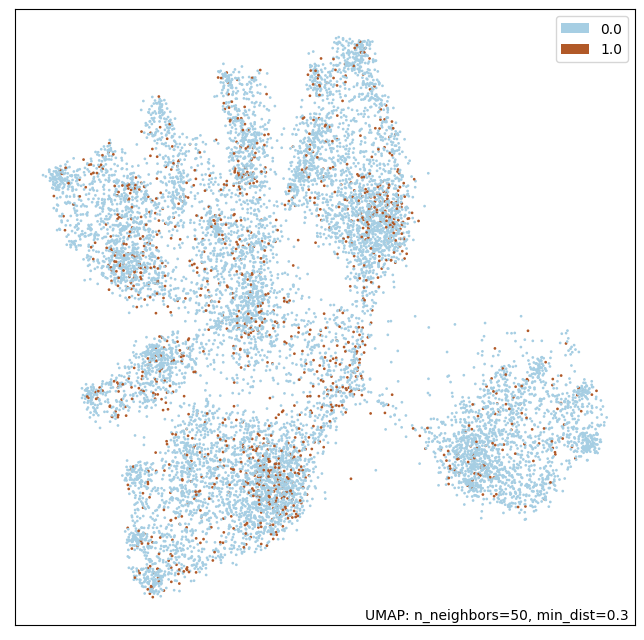

In [35]:
umap.plot.points(mapper, labels=data_umap.endometrioza, color_key_cmap='Paired')

# Correlations

In [36]:
from sklearn.metrics import matthews_corrcoef

In [89]:
from sklearn.metrics.pairwise import additive_chi2_kernel

In [37]:
binary_cols = ['Objaw_lub_procedura:BLEEDING_AFTER_INTERCOURSE',
 'Objaw_lub_procedura:FREQUENT_URINATION',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES',
 'Objaw_lub_procedura:ENLARGED_AND_SORE_BREASTS',
 'Objaw_lub_procedura:WEAKNESS',
 'Objaw_lub_procedura:HEADACHES']

In [52]:
binary_cols_mapping = {
'Objaw_lub_procedura:BLEEDING_AFTER_INTERCOURSE':'BLEEDING_AFTER_INTERCOURSE',
 'Objaw_lub_procedura:FREQUENT_URINATION' :'FREQUENT_URINATION',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE':'REDUCTION_OF_SEX_DRIVE',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES':'ORAL_CONTRACEPTIVES',
 'Objaw_lub_procedura:ENLARGED_AND_SORE_BREASTS':'ENLARGED_AND_SORE_BREASTS',
 'Objaw_lub_procedura:WEAKNESS':'WEAKNESS',
 'Objaw_lub_procedura:HEADACHES':'HEADACHES'
}

In [53]:
data[binary_cols].nunique()

Objaw_lub_procedura:BLEEDING_AFTER_INTERCOURSE                                      2
Objaw_lub_procedura:FREQUENT_URINATION                                              2
Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE                                          2
655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES    2
Objaw_lub_procedura:ENLARGED_AND_SORE_BREASTS                                       2
Objaw_lub_procedura:WEAKNESS                                                        2
Objaw_lub_procedura:HEADACHES                                                       2
dtype: int64

In [112]:
data_corr = data[binary_cols].copy()

In [113]:
data_corr.rename(columns = binary_cols_mapping, inplace=True)

In [114]:
data_corr.columns = data_corr.columns.str.replace('_',' ').str.capitalize()

In [115]:
corr_matrix = data_corr.corr(method = matthews_corrcoef)
corr_matrix = corr_matrix.style.background_gradient(cmap='viridis').set_precision(2)
corr_matrix

,Bleeding after intercourse,Frequent urination,Reduction of sex drive,Oral contraceptives,Enlarged and sore breasts,Weakness,Headaches
Bleeding after intercourse,1.00,0.14,0.20,0.05,0.10,0.08,0.09
Frequent urination,0.14,1.00,0.35,0.06,0.17,0.22,0.23
Reduction of sex drive,0.20,0.35,1.00,0.06,0.16,0.24,0.25
Oral contraceptives,0.05,0.06,0.06,1.00,0.05,0.05,0.08
Enlarged and sore breasts,0.10,0.17,0.16,0.05,1.00,0.16,0.21
Weakness,0.08,0.22,0.24,0.05,0.16,1.00,0.25
Headaches,0.09,0.23,0.25,0.08,0.21,0.25,1.00


In [104]:
import imgkit

In [116]:
html = corr_matrix.render()

In [117]:
imgkit.from_string(html, os.path.join(os.getenv('data_path'),'corr_table_no_imput.png'))

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [109]:
data_corr.fillna(2, inplace=True)

In [110]:
corr_matrix = data_corr.corr(method = matthews_corrcoef)
corr_matrix = corr_matrix.style.background_gradient(cmap='viridis').set_precision(2)
corr_matrix

,Bleeding after intercourse,Frequent urination,Reduction of sex drive,Oral contraceptives,Enlarged and sore breasts,Weakness,Headaches
Bleeding after intercourse,1.00,0.44,0.63,0.17,0.38,0.38,0.40
Frequent urination,0.44,1.00,0.51,0.14,0.34,0.40,0.40
Reduction of sex drive,0.63,0.51,1.00,0.15,0.36,0.42,0.43
Oral contraceptives,0.17,0.14,0.15,1.00,0.12,0.13,0.15
Enlarged and sore breasts,0.38,0.34,0.36,0.12,1.00,0.32,0.36
Weakness,0.38,0.40,0.42,0.13,0.32,1.00,0.40
Headaches,0.40,0.40,0.43,0.15,0.36,0.40,1.00


In [111]:
html = corr_matrix.render()
imgkit.from_string(html, os.path.join(os.getenv('data_path'),'corr_table_imput.png'))

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

# Feature Selection

## Boruta

In [13]:
from feature_selection import feature_selection

In [14]:
from utils import DataSerieEDA

In [15]:
data_serie = DataSerieEDA(
    input_df=data,
    y_columns=[y_col],
    columns=data.columns.drop(['patient_id','index']).tolist(),
)

In [16]:
selector = feature_selection(data_serie)

In [109]:
selector.select_features(methods = ['boruta_shap'])

Warning there are missing values in your data !


  0%|          | 0/100 [00:00<?, ?it/s]

Selected important features for variable endometrioza


In [110]:
selector.feature_ranking['endometrioza']

,boruta_shap,wsm_rank,mm_rank
Objaw_lub_procedura:OVARIAN_CYSTS,0.055252,1,1
Objaw_lub_procedura:KONIZACJA,0.028812,2,2
Objaw_lub_procedura:HERNIA,0.025720,3,3
Objaw_lub_procedura:TONSILS,0.025180,4,4
Objaw_lub_procedura:APPENDEKTOMIA,0.023571,5,5
...,...,...,...
Objaw_lub_procedura:HEAD_INJURY,0.000991,190,190
Maksymalna_amplituda_cykli,0.000943,191,191
209_429_Średnia_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki),0.000942,192,192
121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien,0.000828,193,193


In [17]:
from BorutaShap import BorutaShap
from feature_selection import get_classifier

In [112]:
feature_selector = BorutaShap(
    model=get_classifier(objective='classification', y=data[y_col]),
    importance_measure="Gini",
    classification=True,
)

In [113]:
feature_selector.fit(
    X=data.drop(columns = ['patient_id','index',y_col]), y=data[y_col], n_trials=100, random_state=42, verbose=False
)

Warning there are missing values in your data !


  0%|          | 0/100 [00:00<?, ?it/s]

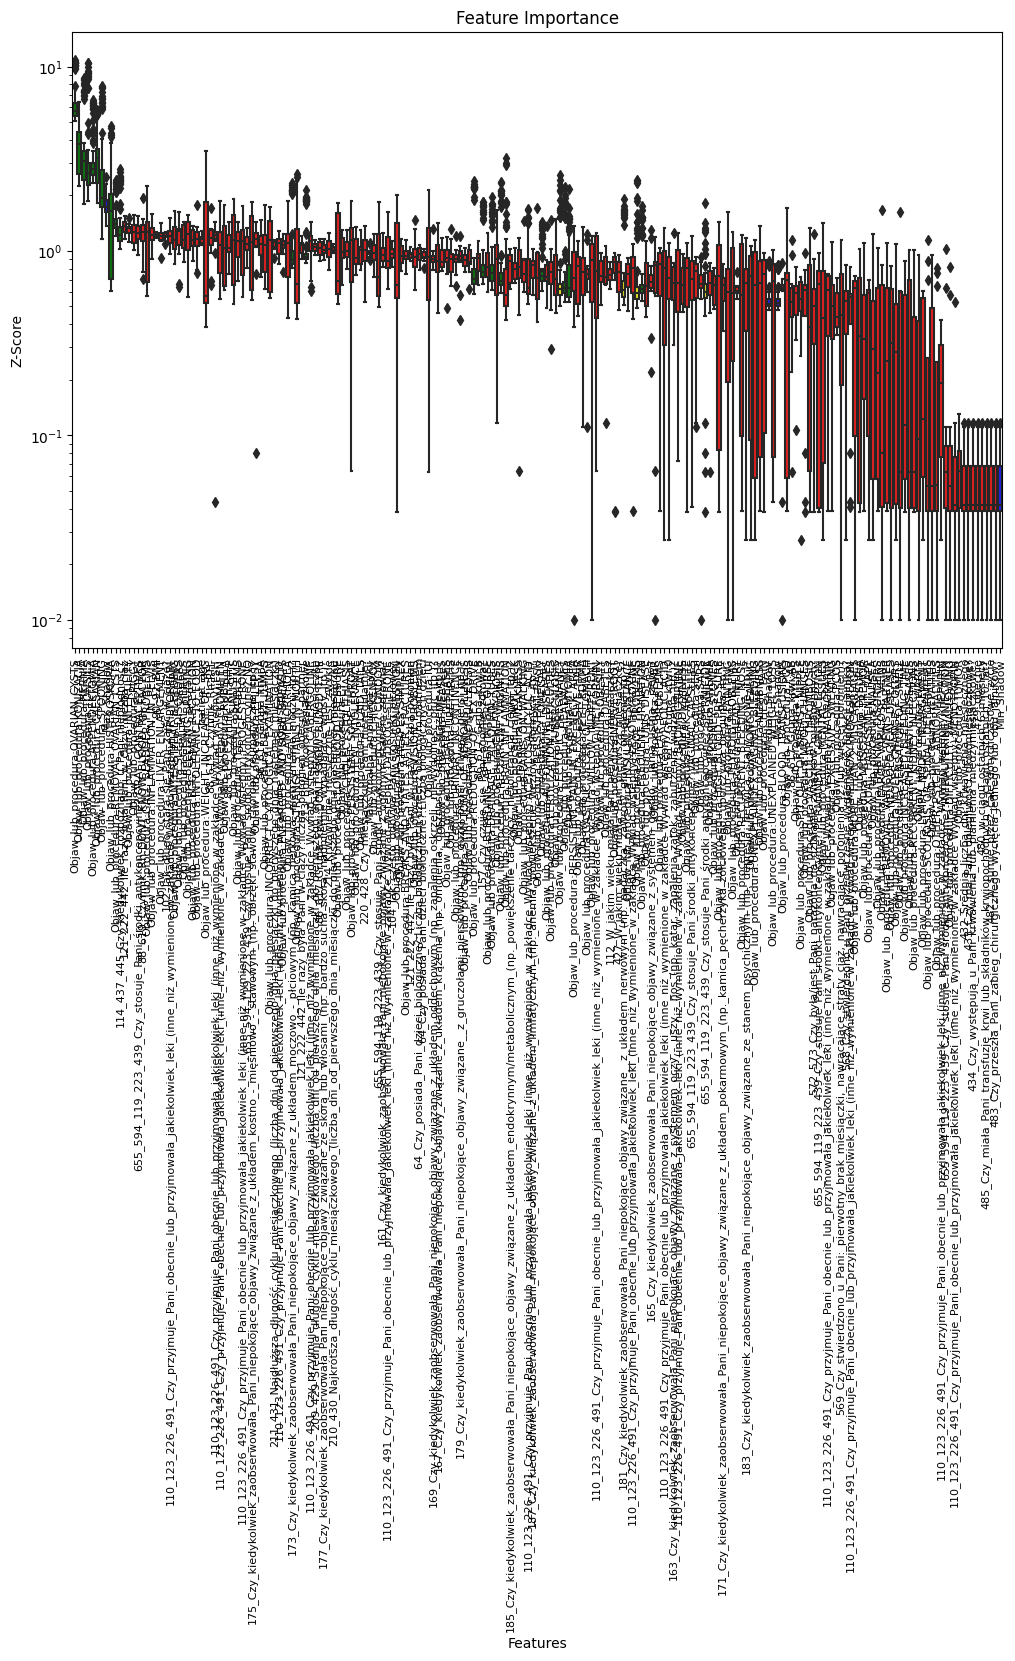

In [114]:
feature_selector.plot(X_size=8, figsize=(12, 8), y_scale="log")

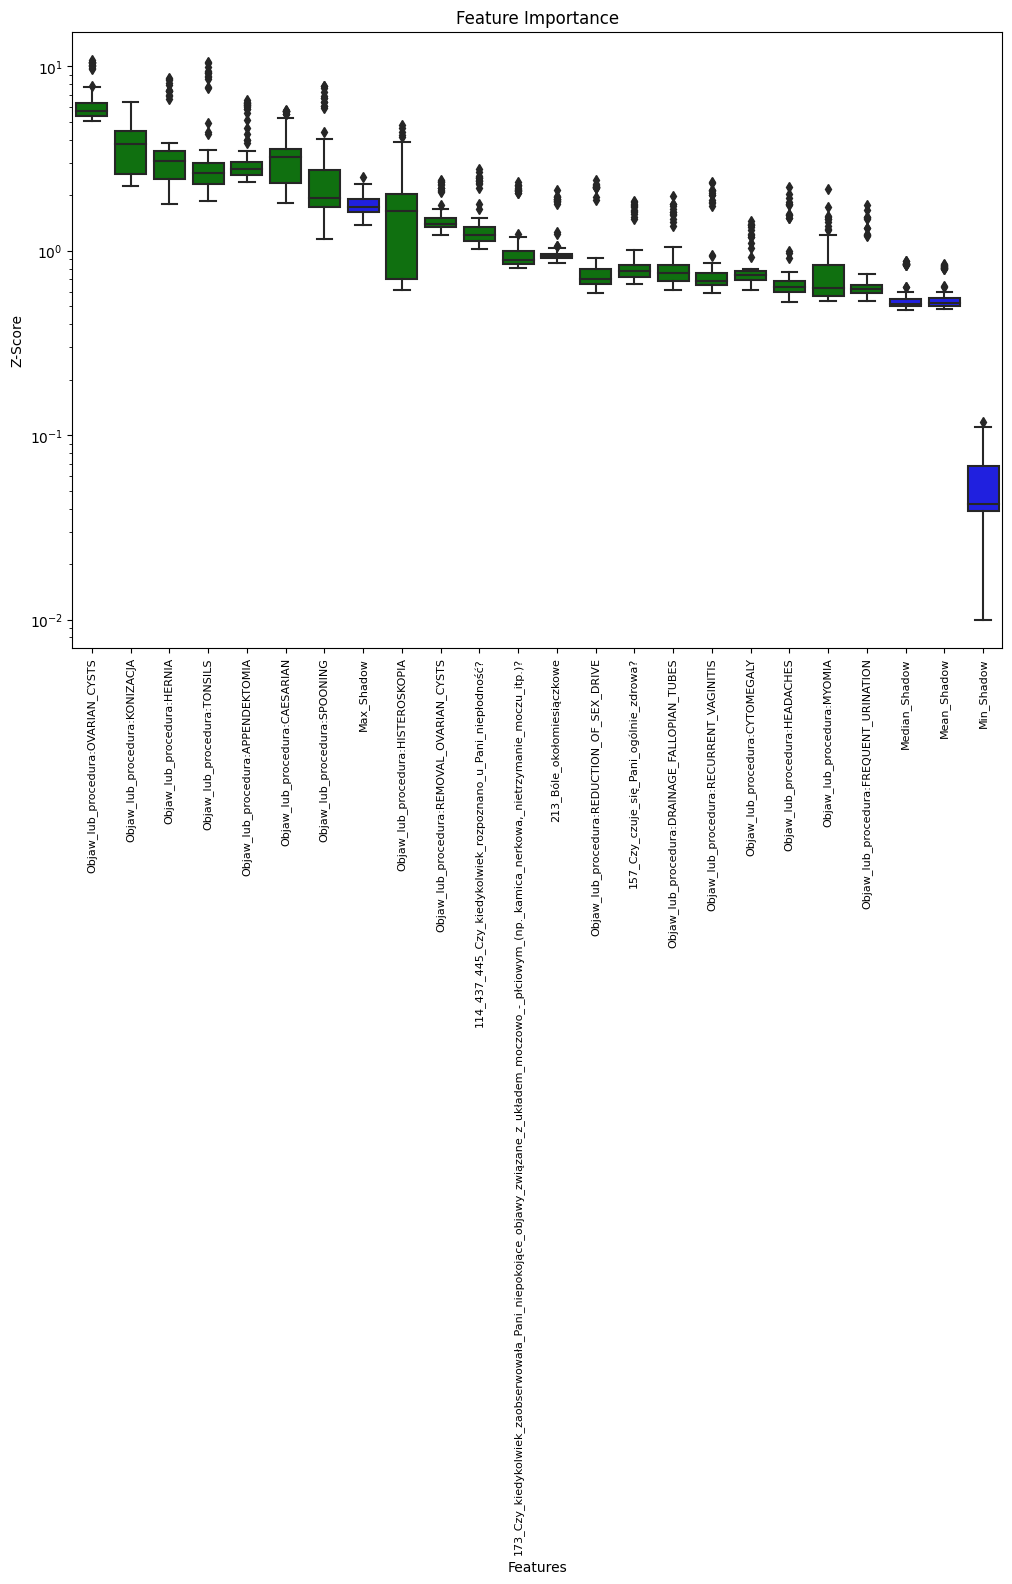

In [115]:
feature_selector.plot(X_size=8, figsize=(12, 8), y_scale="log", which_features='accepted')

In [116]:
order = (
    feature_selector.history_x.drop(
        columns=["Max_Shadow", "Min_Shadow",
                    "Mean_Shadow", "Median_Shadow"]
    ).median()
    + abs(
        feature_selector.history_x.drop(
            columns=["Max_Shadow", "Min_Shadow",
                        "Mean_Shadow", "Median_Shadow"]
        ).min()
    )
)

In [129]:
order.sort_values(ascending=False, inplace = True)

In [130]:
order[:25]

Objaw_lub_procedura:OVARIAN_CYSTS                                                                                                             4.745409
Objaw_lub_procedura:KONIZACJA                                                                                                                 2.821261
Objaw_lub_procedura:CAESARIAN                                                                                                                 2.207026
Objaw_lub_procedura:HERNIA                                                                                                                    2.092919
Objaw_lub_procedura:APPENDEKTOMIA                                                                                                             1.816494
Objaw_lub_procedura:TONSILS                                                                                                                   1.674593
110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymieni

In [118]:
feature_selector.accepted

['173_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_moczowo_-_płciowym_(np._kamica_nerkowa,_nietrzymanie_moczu_itp.)?',
 'Objaw_lub_procedura:HISTEROSKOPIA',
 'Objaw_lub_procedura:RECURRENT_VAGINITIS',
 'Objaw_lub_procedura:TONSILS',
 'Objaw_lub_procedura:MYOMIA',
 'Objaw_lub_procedura:APPENDEKTOMIA',
 '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?',
 '213_Bóle_okołomiesiączkowe',
 'Objaw_lub_procedura:CYTOMEGALY',
 'Objaw_lub_procedura:REMOVAL_OVARIAN_CYSTS',
 'Objaw_lub_procedura:FREQUENT_URINATION',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE',
 'Objaw_lub_procedura:CAESARIAN',
 'Objaw_lub_procedura:OVARIAN_CYSTS',
 'Objaw_lub_procedura:HEADACHES',
 'Objaw_lub_procedura:KONIZACJA',
 'Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES',
 'Objaw_lub_procedura:SPOONING',
 'Objaw_lub_procedura:HERNIA',
 '157_Czy_czuje_się_Pani_ogólnie_zdrowa?']

In [119]:
feature_selector.tentative

['Objaw_lub_procedura:ECTOPIC_PREGNANCY',
 'Objaw_lub_procedura:STOOL_PROBLEMS',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:SPERMICIDE',
 '181_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane__z_układem_nerwowym_(np._padaczka,_zawroty_głowy,_omdlenia_itp.)?']

In [120]:
order.shape

(201,)

In [197]:
order.to_csv(os.path.join(
    os.getenv('data_path'),'paper','boruta_selection_order.csv'
))

## Expert's decisions

In [177]:
from p1_classification_utils import find_optimal_subset_paper

In [178]:
diagnoza = y_col

In [179]:
columns = pd.read_excel(os.path.join(os.getenv('data_cbr'),'istotnosci_zmiennych_Marta',diagnoza+'_feature_importance_paper.xlsx'))

In [180]:
columns

,feature,selected_for_modelling
0,568_Czy_stwierdzono_u_Pani_przedwczesne_wygaśn...,-1
1,569_Czy_stwierdzono_u_Pani:_pierwotny_brak_mie...,1
2,64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba...,1
3,64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba...,1
4,102_Jak_długo_stara_się_Pani_zajść_w_ciążę?,1
...,...,...
196,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub...,-1
197,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub...,-1
198,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub...,-1
199,Maksymalna_amplituda_cykli,1


In [183]:
response, train_cols_full, train_cols_selected = find_optimal_subset_paper(
    data=data,
    target_col=diagnoza,
    columns_feature_selection = columns,
    verbose = 1,
    run_random_impact_measurement = False,
    params = params
)

Initial model: test auc = 0.7584462181669509, auc_overfit = 0.02072590792554596
Checking the impact of columns with importance 0
Objaw_lub_procedura:AUTOIMMUNE_DISEASES: test auc = 0.7528507892764454, auc_overfit = 0.022959867132884226, p_value = 0.24053316600591346, removed = True
Objaw_lub_procedura:CHEST_PAIN: test auc = 0.7541189279870293, auc_overfit = 0.022117141733230872, p_value = 0.24053316600591346, removed = True
Objaw_lub_procedura:CHLAMYDIOSIS: test auc = 0.7525029838108195, auc_overfit = 0.022789571844935352, p_value = 0.3728264073091659, removed = True
Objaw_lub_procedura:EXCESSIVE_SWEATING: test auc = 0.7547522710752758, auc_overfit = 0.023028676157371253, p_value = 0.702075702075702, removed = True
Objaw_lub_procedura:FAINTING: test auc = 0.7549012322687635, auc_overfit = 0.02198101444292866, p_value = 0.1428165673160111, removed = True
Objaw_lub_procedura:GASTRIC_ULCER_OF_STOMACH: test auc = 0.7520634393499742, auc_overfit = 0.02082191135062128, p_value = 0.2405331660

In [184]:
fig = go.Figure()
for key,value in response.items():
    fig.add_trace(
        go.Box(
            y=value.test_auc,
            name = key
            )
    )
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
    showlegend=False
)
fig.show()

In [185]:
train_cols_selected

['102_Jak_długo_stara_się_Pani_zajść_w_ciążę?',
 '433_Czy_ma_Pani_dolegliwości_okołomiesiączkowe?',
 'Objaw_lub_procedura:BLEEDING_AFTER_INTERCOURSE',
 'Objaw_lub_procedura:RECURRENT_VAGINITIS',
 'Objaw_lub_procedura:URINARY_INCONTINENCE',
 'patient_age',
 'Objaw_lub_procedura:WEAKNESS',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_ciaz',
 '211_431_Najdłuższa_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)',
 'Objaw_lub_procedura:URETHRITIS',
 'Objaw_lub_procedura:MYOMIA',
 'Objaw_lub_procedura:LOW_BLOOD_PRESSURE',
 'Objaw_lub_procedura:ANEMIA',
 '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?',
 '64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba biologicznych dzieci z obecnym partnerem',
 'Objaw_lub_procedura:UNEXPLAINDEX_VAGINAL_BLEEDING',
 'Objaw_lub_procedura:PAINS_ON_WALKING',
 'Objaw_lub_procedura:WEAK_APPETITE',
 'Objaw_lub_procedura:MENTAL_ISSUES',
 '214_Krwawienie_miesięczne_jest_zwykle',
 'Objaw_lub

In [186]:
train_cols_selected.__len__()

67

## Recursive Feature Selection

In [199]:
from p1_classification_utils import recursive_feature_selection

In [194]:
order

Objaw_lub_procedura:OVARIAN_CYSTS                                                                                                     4.745409
Objaw_lub_procedura:KONIZACJA                                                                                                         2.821261
Objaw_lub_procedura:CAESARIAN                                                                                                         2.207026
Objaw_lub_procedura:HERNIA                                                                                                            2.092919
Objaw_lub_procedura:APPENDEKTOMIA                                                                                                     1.816494
                                                                                                                                        ...   
482_w_sumie_przez_całe_dotychczasowe_życie                                                                                            0.033573

In [200]:
response, train_cols_full, train_cols_selected = recursive_feature_selection(
    data=data,
    target_col=diagnoza,
    columns_feature_selection = order,
    verbose = 1,
    run_random_impact_measurement = False,
    params = params
)

Initial model: test auc = 0.7859425356107844, auc_overfit = 0.012867516926609035
Objaw_lub_procedura:RECURRENT_KIDNEY_INFECTIONS: test auc = 0.7874622685157578, auc_overfit = 0.012506421251857969, p_value = 0.702075702075702, removed = True
210_430_Najkrótsza_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki): test auc = 0.7860073645007395, auc_overfit = 0.012585474464144708, p_value = 0.017805701899139045, removed = True
483_Czy_przeszła_Pani_zabieg_chirurgicznego_wycięcia_jednego_lub_obu_jajników?: test auc = 0.786070664407441, auc_overfit = 0.012627564506274447, p_value = 0.8547008547008547, removed = True
479_obecnie: test auc = 0.7859053048685578, auc_overfit = 0.012639387847090622, p_value = 0.9615384615384616, removed = True
480_w_ciągu_ostatnich_6_miesięcy: test auc = 0.7860073645007395, auc_overfit = 0.012585474464144708, p_value = 0.9615384615384616, removed = True
434_Czy_występują_u_Pani_krwawienia_lub_plamienia_m

In [201]:
train_cols_selected

['655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:CONDOM',
 'Objaw_lub_procedura:FEVER',
 'Objaw_lub_procedura:VISION_PROBLEMS',
 'Objaw_lub_procedura:LYMPH_NODE_ENLARGEMENT',
 'Objaw_lub_procedura:KIDNEY_STONES',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):MEDROXYPROGESTERON',
 'patient_age',
 '568_Czy_stwierdzono_u_Pani_przedwczesne_wygaśnięcie_funkcji_jajnika?',
 'Objaw_lub_procedura:EPILEPSY',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):CLOMIFEN',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):BROMOCRIPTINE',
 'Objaw_lub_procedura:EXCESSIVE_SWEATING',
 'Objaw_lub_procedura:WEIGHT_INCREASE_OF_5KG',
 'Objaw_lub_procedura:MYOMIA',
 'Objaw_lub_procedura:TUBERCULOSIS',
 'Objaw_lub_procedura:APPENDEKTOMIA',
 'Objaw_lub_procedura:GAST

In [202]:
from read_data import save_dill, get_dill

In [203]:
save_dill(response, 'recursive_selection_paper', env_variable='data_path')

Done


In [17]:
response = get_dill('recursive_selection_paper', env_variable='data_path')

In [19]:
fig = go.Figure()
for key,value in response.items():
    fig.add_trace(
        go.Box(
            y=value.test_auc,
            name = key
            )
    )
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
    showlegend=False
)
fig.show()

# Comparison of subsets

In [47]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [48]:
def params_search(data, diagnosis, train_cols, n_HP_points_to_test = 100):
    data = data[train_cols + [diagnosis]].copy()
    data.rename(
            columns=dict(
                zip(
                    data.columns,
                    data.columns.str.normalize("NFKD")
                    .str.encode("ascii", errors="ignore")
                    .str.decode("utf-8")
                    .tolist(),
                )
            ),
            inplace=True
        )
    data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_+-]+', '', x),
                       inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = diagnosis), data[diagnosis], test_size=0.20, random_state=314)



    #This parameter defines the number of HP points to be tested

    param_test ={
                'learning_rate': [1e-3, 1e-2, 1e-1,2e-3, 2e-2,3e-3, 3e-2,4e-3, 5e-2],
                'num_leaves': sp_randint(4, 32), 
                'max_depth': sp_randint(2, 8),
                "max_bin": sp_randint(8, 64),
                # 'min_split_gain': [1e-3, 1e-2, 1e-1],
                'subsample_freq': sp_randint(2, 64),
                'subsample': sp_uniform(loc=0.2, scale=.8),
                'colsample_bytree': sp_uniform(loc=0.2, scale=0.8),
                'reg_alpha': [1e-1, 2e-1, 5e-2, 7e-2],
                'reg_lambda': [1e-1, 2e-1, 5e-2, 7e-2]
                }
    clf = lgb.LGBMClassifier(random_state=314, verbose=-1, metric=["auc", "logloss", "acc"], n_estimators=1000, n_jobs=8)

    gs_sample_weight = RandomizedSearchCV(
        estimator=clf, param_distributions=param_test, 
        n_iter=n_HP_points_to_test,
        scoring='neg_root_mean_squared_error',
        cv=3,
        refit=True,
        random_state=314,
        verbose=-1)
    fit_params={
                "eval_metric" : 'neg_root_mean_squared_error', 
                "eval_set" : [(X_test,y_test)],
                'eval_names': ['valid'],
                'callbacks': [
                    lgb.early_stopping(50, verbose=1),
                    lgb.log_evaluation(200)
                    ],
                'categorical_feature': 'auto'}
    rs_cv_results = gs_sample_weight.fit(X_train, y_train, **fit_params)
    return rs_cv_results.best_params_

## Boruta

In [59]:
columns_boruta = ['173_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_moczowo_-_płciowym_(np._kamica_nerkowa,_nietrzymanie_moczu_itp.)?',
 'Objaw_lub_procedura:HISTEROSKOPIA',
 'Objaw_lub_procedura:RECURRENT_VAGINITIS',
 'Objaw_lub_procedura:TONSILS',
 'Objaw_lub_procedura:MYOMIA',
 'Objaw_lub_procedura:APPENDEKTOMIA',
 '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?',
 '213_Bóle_okołomiesiączkowe',
 'Objaw_lub_procedura:CYTOMEGALY',
 'Objaw_lub_procedura:REMOVAL_OVARIAN_CYSTS',
 'Objaw_lub_procedura:FREQUENT_URINATION',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE',
 'Objaw_lub_procedura:CAESARIAN',
 'Objaw_lub_procedura:OVARIAN_CYSTS',
 'Objaw_lub_procedura:HEADACHES',
 'Objaw_lub_procedura:KONIZACJA',
 'Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES',
 'Objaw_lub_procedura:SPOONING',
 'Objaw_lub_procedura:HERNIA',
 '157_Czy_czuje_się_Pani_ogólnie_zdrowa?']

In [154]:
best_params_boruta = params_search(data,diagnosis=y_col,train_cols=columns_boruta, n_HP_points_to_test= 1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid's auc: 0.769818
Early stopping, best iteration is:
[61]	valid's auc: 0.779362
Early stopping, best iteration is:
[82]	valid's auc: 0.782171
Early stopping, best iteration is:
[82]	valid's auc: 0.782171
Early stopping, best iteration is:
[82]	valid's auc: 0.782171
Early stopping, best iteration is:
[114]	valid's auc: 0.782483
Early stopping, best iteration is:
[114]	valid's auc: 0.782483
Early stopping, best iteration is:
[114]	valid's auc: 0.782483
Early stopping, best iteration is:
[114]	valid's auc: 0.782483
Early stopping, best iteration is:
[114]	valid's auc: 0.782483
Early stopping, best iteration is:
[114]	valid's auc: 0.782483
Early stopping, best iteration is:
[114]	valid's auc: 0.782483
Early stopping, best iteration is:
[114]	valid's auc: 0.782483
Early stopping, best iteration is:
[114]	valid's auc: 0.782483
Early stopping, best iteration is:
[114]	valid's auc: 0.782483


In [60]:
best_params_boruta = {'colsample_bytree': 0.4982519805743373,
 'learning_rate': 0.1,
 'max_bin': 39,
 'max_depth': 2,
 'num_leaves': 31,
 'reg_alpha': 0.2,
 'reg_lambda': 0.2,
 'subsample': 0.30156937389053456,
 'subsample_freq': 51}

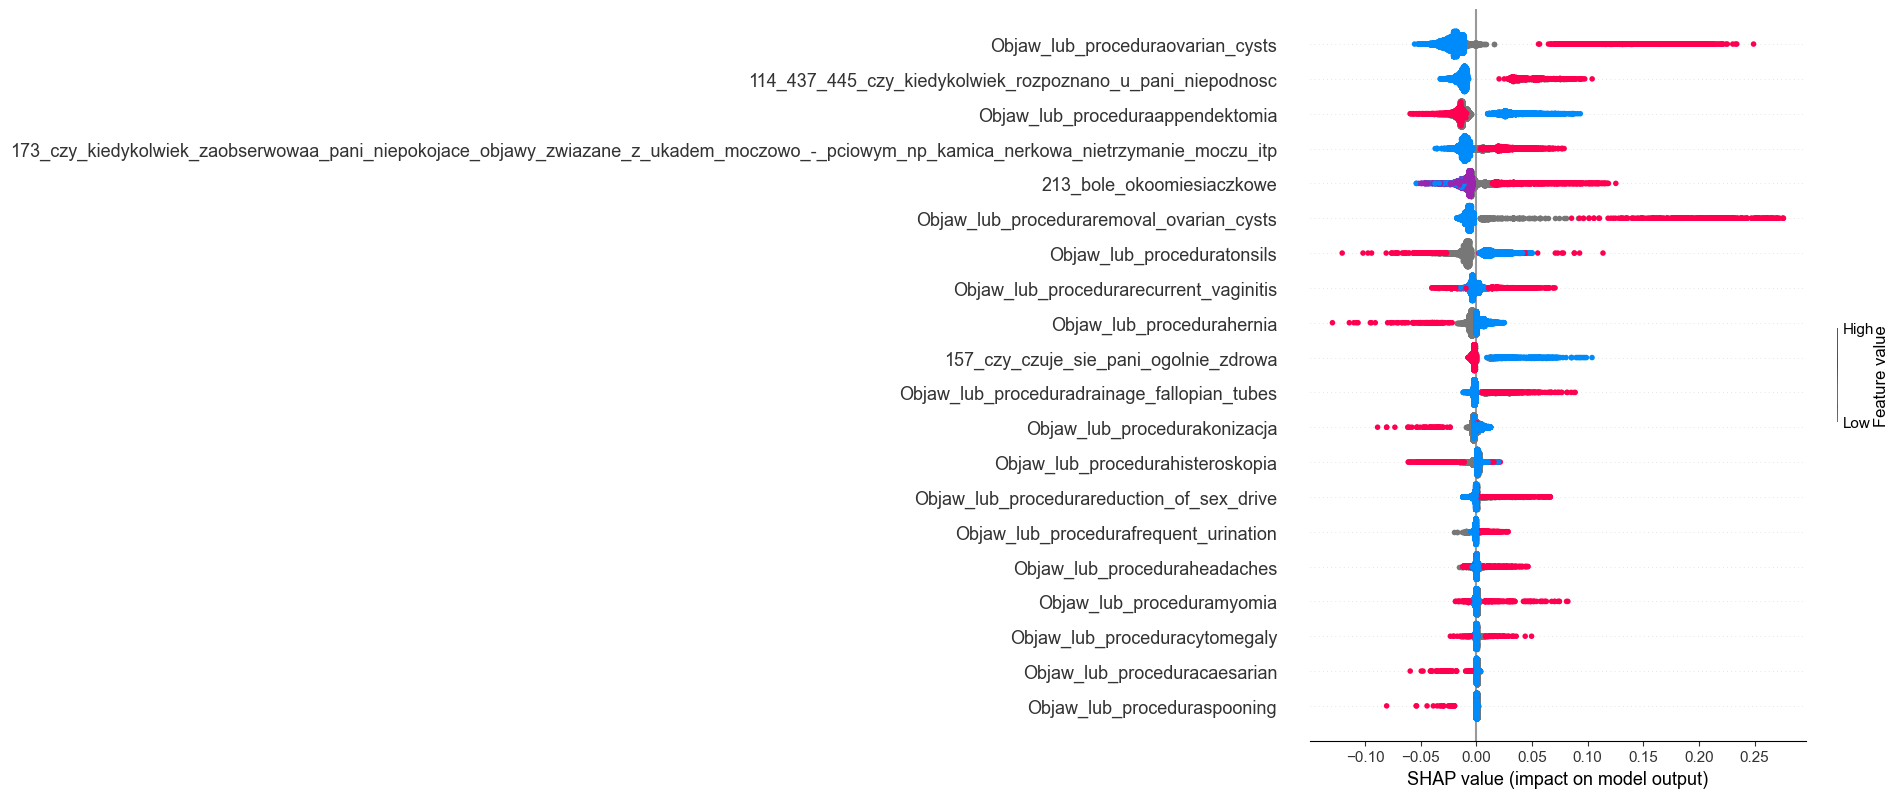

In [63]:
metrics_folds_boruta = train_folds_imputation(
    target_col=y_col,
    train_cols=columns_boruta,
    data=data,
    verbose=1,
    params=best_params_boruta,
    calculate_shap = True
)

In [64]:
metrics_folds_boruta

({'test': {'Precision': 0.261028293276544,
   'Recall': 0.6941747572815534,
   'Accuracy': 0.7625010576190879,
   'F1 weighted': 0.8036076309819538,
   'AUC': 0.7991992791149757,
   'matthews_corrcoef': 0.3173362192671843,
   'specificity': 0.7704809600302371},
  'train': {'Precision': 0.26410509529956716,
   'Recall': 0.7034789644012945,
   'Accuracy': 0.7640028767239191,
   'F1 weighted': 0.8048883876811187,
   'AUC': 0.8115879208755752,
   'matthews_corrcoef': 0.3239350155655169,
   'specificity': 0.7704809600302371}},
 {'y_test': array([0., 0., 0., ..., 1., 0., 0.]),
  'y_predicted_test': array([1, 0, 0, ..., 1, 0, 0]),
  'predictions_test': array([0.09906089, 0.06142778, 0.09434076, ..., 0.27690787, 0.06801541,
         0.02607301]),
  'y_train': array([0., 0., 1., ..., 0., 0., 0.]),
  'y_predicted_train': array([0, 0, 1, ..., 0, 0, 0]),
  'predictions_train': array([0.05309309, 0.07832788, 0.13091519, ..., 0.02607301, 0.05144858,
         0.02607301])})

In [18]:
metrics_folds_boruta

{'test': {'Precision': 0.45429864253393665,
  'Recall': 0.40614886731391586,
  'Accuracy': 0.8868770623572214,
  'F1 weighted': 0.8840598548952572,
  'AUC': 0.7991992791149757,
  'matthews_corrcoef': 0.3670239969727964},
 'train': {'Precision': 0.46183035714285714,
  'Recall': 0.4184870550161812,
  'Accuracy': 0.888188510026229,
  'F1 weighted': 0.8857406558683251,
  'AUC': 0.8115879208755752,
  'matthews_corrcoef': 0.37772904357617126}}

In [15]:
metrics_boruta =[]
for i in range(25):
    metrics_boruta.append(train_folds_imputation(
        target_col=y_col,
        train_cols=columns_boruta,
        data=data,
        verbose=1,
        params=best_params_boruta,
        calculate_shap = False,
        random_state = i
    ))

## Expert's decision

In [65]:
columns_ed = ['102_Jak_długo_stara_się_Pani_zajść_w_ciążę?',
 '433_Czy_ma_Pani_dolegliwości_okołomiesiączkowe?',
 'Objaw_lub_procedura:BLEEDING_AFTER_INTERCOURSE',
 'Objaw_lub_procedura:RECURRENT_VAGINITIS',
 'Objaw_lub_procedura:URINARY_INCONTINENCE',
 'patient_age',
 'Objaw_lub_procedura:WEAKNESS',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_ciaz',
 '211_431_Najdłuższa_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)',
 'Objaw_lub_procedura:URETHRITIS',
 'Objaw_lub_procedura:MYOMIA',
 'Objaw_lub_procedura:LOW_BLOOD_PRESSURE',
 'Objaw_lub_procedura:ANEMIA',
 '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?',
 '64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba biologicznych dzieci z obecnym partnerem',
 'Objaw_lub_procedura:UNEXPLAINDEX_VAGINAL_BLEEDING',
 'Objaw_lub_procedura:PAINS_ON_WALKING',
 'Objaw_lub_procedura:WEAK_APPETITE',
 'Objaw_lub_procedura:MENTAL_ISSUES',
 '214_Krwawienie_miesięczne_jest_zwykle',
 'Objaw_lub_procedura:MORE_THAN_2_MISCARRIAGES',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:NO',
 'Objaw_lub_procedura:NAUSEA',
 '64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba biologicznych dzieci',
 'Objaw_lub_procedura:HEAT_INTOLERANCE',
 'Objaw_lub_procedura:SINUSITIS',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien',
 '432_Średnia_liczba_dni_krwawienia_miesięcznego',
 'Objaw_lub_procedura:HEADACHES',
 'Objaw_lub_procedura:PYLYPS',
 '210_430_Najkrótsza_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)',
 'Objaw_lub_procedura:DYSURIA',
 'Objaw_lub_procedura:PERSISTENT_RASH',
 'Objaw_lub_procedura:MOOD_CHANGES',
 'Objaw_lub_procedura:VASCULAR_THROMBOSIS',
 'Objaw_lub_procedura:AMENORRHOEA',
 'Objaw_lub_procedura:CHOLECYSTOLITHIASIS',
 '434_Czy_występują_u_Pani_krwawienia_lub_plamienia_międzymiesiączkowe?',
 'Objaw_lub_procedura:SEPSI',
 'Objaw_lub_procedura:RECURRENT_KIDNEY_INFECTIONS',
 'Objaw_lub_procedura:ENLARGED_AND_SORE_BREASTS',
 'Objaw_lub_procedura:BREAST_LUMPS',
 'Objaw_lub_procedura:RHEUMATIC_DISEASES',
 '213_Bóle_okołomiesiączkowe',
 '220_428_Czy_miesiączkuje_Pani_nieregularnie?',
 'Maksymalna_amplituda_cykli',
 '104_Jak_często_odbywa_Pani_stosunki_płciowe?',
 'Objaw_lub_procedura:ECTOPIC_PREGNANCY',
 'Objaw_lub_procedura:HIGH_BLOOD_PRESSURE',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien_obecny_partner',
 'Objaw_lub_procedura:FREQUENT_URINATION',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE',
 'Objaw_lub_procedura:INFLAMMATION_IN_PELVIS',
 '209_429_Średnia_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)',
 'Objaw_lub_procedura:STOOL_PROBLEMS',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES',
 '88_619_Czynnik_Rh:RH-',
 '427_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?',
 'Objaw_lub_procedura:SLEEP_DISORDERS',
 '112_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?',
 'Objaw_lub_procedura:PCOS',
 '90_92_BMI',
 '569_Czy_stwierdzono_u_Pani:_pierwotny_brak_miesiączki,_nawracające_straty_ciąż,_nawracające_poronienia_(2_lub_więcej_poronień)?',
 'Objaw_lub_procedura:KONIZACJA',
 'Objaw_lub_procedura:SPIT_OUT_OF_BREAST_NIPPLE',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:INTRAUTERINE_INJECTION',
 'Objaw_lub_procedura:DIZZINESS']

In [188]:
best_params_ed = params_search(data,diagnosis=y_col,train_cols=columns_ed, n_HP_points_to_test= 1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid's auc: 0.733842
Early stopping, best iteration is:
[10]	valid's auc: 0.733842
Early stopping, best iteration is:
[10]	valid's auc: 0.733842
Early stopping, best iteration is:
[51]	valid's auc: 0.748565
Early stopping, best iteration is:
[51]	valid's auc: 0.748565
Early stopping, best iteration is:
[51]	valid's auc: 0.748565
Early stopping, best iteration is:
[51]	valid's auc: 0.748565
Early stopping, best iteration is:
[51]	valid's auc: 0.748565
[200]	valid's auc: 0.755511
[400]	valid's auc: 0.760449
Early stopping, best iteration is:
[374]	valid's auc: 0.761659
[200]	valid's auc: 0.730163
[400]	valid's auc: 0.738993
Early stopping, best iteration is:
[374]	valid's auc: 0.761659
[200]	valid's auc: 0.719175
[400]	valid's auc: 0.724075
Early stopping, best iteration is:
[374]	valid's auc: 0.761659
[200]	valid's auc: 0.73003
[400]	valid's auc: 0.735932
Early stopping, best iteration 

In [66]:
best_params_ed = {'colsample_bytree': 0.2923888035438325,
 'learning_rate': 0.03,
 'max_bin': 46,
 'max_depth': 6,
 'num_leaves': 20,
 'reg_alpha': 0.05,
 'reg_lambda': 0.07,
 'subsample': 0.7608612667900865,
 'subsample_freq': 48}

 99%|===================| 2336/2363 [00:32<00:00]        

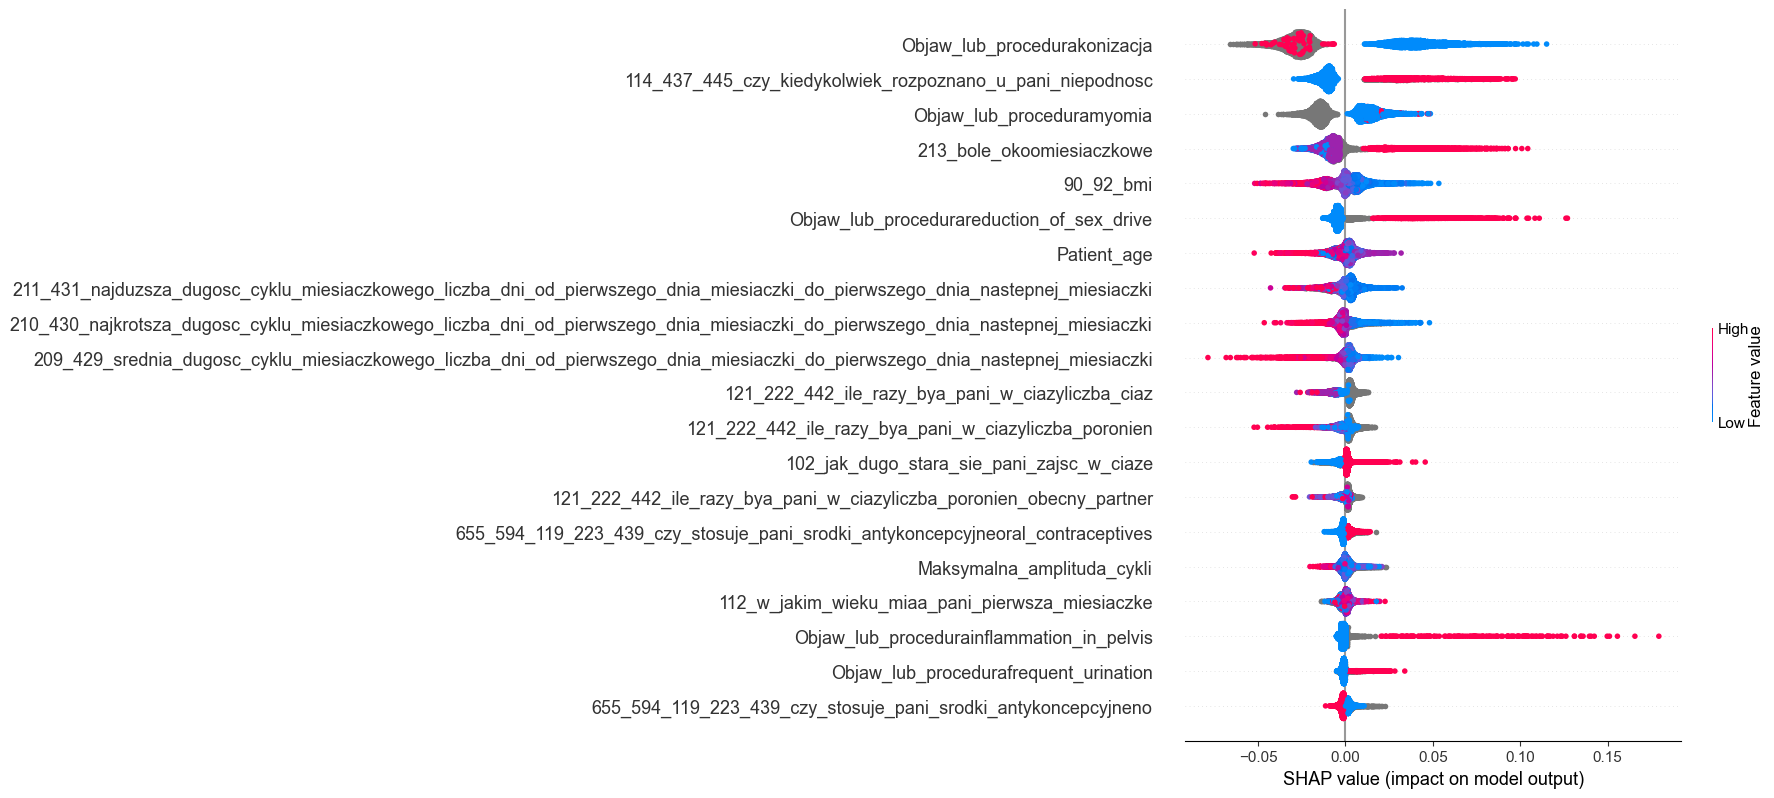

In [67]:
metrics_folds_ed = train_folds_imputation(
    target_col=y_col,
    train_cols=columns_ed,
    data=data,
    verbose=1,
    params=best_params_ed,
    calculate_shap = True
)

In [68]:
metrics_folds_ed

({'test': {'Precision': 0.2286780383795309,
   'Recall': 0.6941747572815534,
   'Accuracy': 0.723157627548862,
   'F1 weighted': 0.774304867568058,
   'AUC': 0.7795849085683304,
   'matthews_corrcoef': 0.27657733472511975,
   'specificity': 0.7265425682698667},
  'train': {'Precision': 0.2634426558012157,
   'Recall': 0.7977346278317152,
   'Accuracy': 0.7456003045942973,
   'F1 weighted': 0.7925556546357814,
   'AUC': 0.8494430473041426,
   'matthews_corrcoef': 0.353416340254967,
   'specificity': 0.7265425682698667}},
 {'y_test': array([0., 0., 0., ..., 1., 0., 0.]),
  'y_predicted_test': array([0, 0, 0, ..., 1, 1, 0]),
  'predictions_test': array([0.06123793, 0.08328962, 0.06669557, ..., 0.12259866, 0.14026731,
         0.04392808]),
  'y_train': array([0., 0., 1., ..., 0., 0., 0.]),
  'y_predicted_train': array([0, 0, 1, ..., 0, 0, 0]),
  'predictions_train': array([0.09184246, 0.08376676, 0.18487993, ..., 0.02545103, 0.04678653,
         0.04818578])})

In [18]:
metrics_ed =[]
for i in range(25):
    metrics_ed.append(train_folds_imputation(
        target_col=y_col,
        train_cols=columns_ed,
        data=data,
        verbose=1,
        params=best_params_ed,
        calculate_shap = False,
        random_state = i
    ))

In [32]:
mapper_columns_ed = {}
for column in columns_ed:
    try:
        mapper_columns_ed[column] = columns_custom_mapping[column]
    except:
        mapper_columns_ed[column] = ''

In [15]:
mapper_columns_ed = {'102_Jak_długo_stara_się_Pani_zajść_w_ciążę?': 'Years of trying to get pregnant',
 '433_Czy_ma_Pani_dolegliwości_okołomiesiączkowe?': 'menstrual symptoms',
 'Objaw_lub_procedura:BLEEDING_AFTER_INTERCOURSE': 'BLEEDING AFTER INTERCOURSE',
 'Objaw_lub_procedura:RECURRENT_VAGINITIS': 'RECURRENT VAGINITIS',
 'Objaw_lub_procedura:URINARY_INCONTINENCE': 'URINARY INCONTINENCE',
 'patient_age': 'Patient age',
 'Objaw_lub_procedura:WEAKNESS': 'WEAKNESS',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_ciaz': 'Number of pregnancies',
 '211_431_Najdłuższa_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)': 'Longest menstrual cycle lenght',
 'Objaw_lub_procedura:URETHRITIS': 'URETHRITIS',
 'Objaw_lub_procedura:MYOMIA': 'MYOMIA',
 'Objaw_lub_procedura:LOW_BLOOD_PRESSURE': 'LOW_BLOOD_PRESSURE',
 'Objaw_lub_procedura:ANEMIA': 'ANEMIA',
 '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?': 'Diagnosed Infertility',
 '64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba biologicznych dzieci z obecnym partnerem': 'Number of biological children with current partner',
 'Objaw_lub_procedura:UNEXPLAINDEX_VAGINAL_BLEEDING': 'UNEXPLAINDEX VAGINAL BLEEDING',
 'Objaw_lub_procedura:PAINS_ON_WALKING': 'PAINS ON WALKING',
 'Objaw_lub_procedura:WEAK_APPETITE': 'WEAK APPETITE',
 'Objaw_lub_procedura:MENTAL_ISSUES': 'MENTAL ISSUES',
 '214_Krwawienie_miesięczne_jest_zwykle': 'Abundance of the menstruation',
 'Objaw_lub_procedura:MORE_THAN_2_MISCARRIAGES': 'MORE THAN 2 MISCARRIAGES',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:NO': 'No anticonception',
 'Objaw_lub_procedura:NAUSEA': 'NAUSEA',
 '64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba biologicznych dzieci': 'Number of biological children',
 'Objaw_lub_procedura:HEAT_INTOLERANCE': 'HEAT INTOLERANCE',
 'Objaw_lub_procedura:SINUSITIS': 'SINUSITIS',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien': 'Number of miscarriages',
 '432_Średnia_liczba_dni_krwawienia_miesięcznego': 'Average duration ofmenstruation',
 'Objaw_lub_procedura:HEADACHES': 'HEADACHES',
 'Objaw_lub_procedura:PYLYPS': 'PYLYPS',
 '210_430_Najkrótsza_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)': 'Shortest menstrual cycle lenght',
 'Objaw_lub_procedura:DYSURIA': 'DYSURIA',
 'Objaw_lub_procedura:PERSISTENT_RASH': 'PERSISTENT RASH',
 'Objaw_lub_procedura:MOOD_CHANGES': 'MOOD CHANGES',
 'Objaw_lub_procedura:VASCULAR_THROMBOSIS': 'VASCULAR THROMBOSIS',
 'Objaw_lub_procedura:AMENORRHOEA': 'AMENORRHOEA',
 'Objaw_lub_procedura:CHOLECYSTOLITHIASIS': 'CHOLECYSTOLITHIASIS',
 '434_Czy_występują_u_Pani_krwawienia_lub_plamienia_międzymiesiączkowe?': 'intermenstrual spotting',
 'Objaw_lub_procedura:SEPSI': 'SEPSI',
 'Objaw_lub_procedura:RECURRENT_KIDNEY_INFECTIONS': 'RECURRENT KIDNEY INFECTIONS',
 'Objaw_lub_procedura:ENLARGED_AND_SORE_BREASTS': 'ENLARGED AND SORE BREASTS',
 'Objaw_lub_procedura:BREAST_LUMPS': 'BREAST LUMPS',
 'Objaw_lub_procedura:RHEUMATIC_DISEASES': 'RHEUMATIC DISEASES',
 '213_Bóle_okołomiesiączkowe': 'Menstrual pains',
 '220_428_Czy_miesiączkuje_Pani_nieregularnie?': 'Irregular periods',
 'Maksymalna_amplituda_cykli': 'Maximum difference between shortest and longest period',
 '104_Jak_często_odbywa_Pani_stosunki_płciowe?': 'Frequency of sexual intercourse',
 'Objaw_lub_procedura:ECTOPIC_PREGNANCY': 'ECTOPIC PREGNANCY',
 'Objaw_lub_procedura:HIGH_BLOOD_PRESSURE': 'HIGH BLOOD PRESSURE',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien_obecny_partner': 'number of miscarriages with current partner',
 'Objaw_lub_procedura:FREQUENT_URINATION': 'FREQUENT URINATION',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE': 'REDUCTION OF SEX DRIVE',
 'Objaw_lub_procedura:INFLAMMATION_IN_PELVIS': 'INFLAMMATION IN PELVIS',
 '209_429_Średnia_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)': 'Average menstrual cycle lenght',
 'Objaw_lub_procedura:STOOL_PROBLEMS': 'STOOL PROBLEMS',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES': 'ORAL CONTRACEPTIVES',
 '88_619_Czynnik_Rh:RH-': 'RH-',
 '427_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?': 'First menarche',
 'Objaw_lub_procedura:SLEEP_DISORDERS': 'SLEEP DISORDERS',
 '112_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?': 'Age at menarche',
 'Objaw_lub_procedura:PCOS': 'PCOS',
 '90_92_BMI': 'BMI',
 '569_Czy_stwierdzono_u_Pani:_pierwotny_brak_miesiączki,_nawracające_straty_ciąż,_nawracające_poronienia_(2_lub_więcej_poronień)?': 'Recurrent miscarriages',
 'Objaw_lub_procedura:KONIZACJA': 'Conization',
 'Objaw_lub_procedura:SPIT_OUT_OF_BREAST_NIPPLE': 'SPIT OUT OF BREAST NIPPLE',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:INTRAUTERINE_INJECTION': 'INTRAUTERINE INJECTION',
 'Objaw_lub_procedura:DIZZINESS': 'DIZZINESS'}

In [38]:
pd.Series(list(mapper_columns_ed.values())).str.capitalize().tolist()

['Years of trying to get pregnant',
 'Menstrual symptoms',
 'Bleeding after intercourse',
 'Recurrent vaginitis',
 'Urinary incontinence',
 'Patient age',
 'Weakness',
 'Number of pregnancies',
 'Longest menstrual cycle lenght',
 'Urethritis',
 'Myomia',
 'Low_blood_pressure',
 'Anemia',
 'Diagnosed infertility',
 'Number of biological children with current partner',
 'Unexplaindex vaginal bleeding',
 'Pains on walking',
 'Weak appetite',
 'Mental issues',
 'Abundance of the menstruation',
 'More than 2 miscarriages',
 'No anticonception',
 'Nausea',
 'Number of biological children',
 'Heat intolerance',
 'Sinusitis',
 'Number of miscarriages',
 'Average duration ofmenstruation',
 'Headaches',
 'Pylyps',
 'Shortest menstrual cycle lenght',
 'Dysuria',
 'Persistent rash',
 'Mood changes',
 'Vascular thrombosis',
 'Amenorrhoea',
 'Cholecystolithiasis',
 'Intermenstrual spotting',
 'Sepsi',
 'Recurrent kidney infections',
 'Enlarged and sore breasts',
 'Breast lumps',
 'Rheumatic diseases

## Recursive Feature Selection

In [69]:
columns_rs = ['655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:CONDOM',
 'Objaw_lub_procedura:FEVER',
 'Objaw_lub_procedura:VISION_PROBLEMS',
 'Objaw_lub_procedura:LYMPH_NODE_ENLARGEMENT',
 'Objaw_lub_procedura:KIDNEY_STONES',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):MEDROXYPROGESTERON',
 'patient_age',
 '568_Czy_stwierdzono_u_Pani_przedwczesne_wygaśnięcie_funkcji_jajnika?',
 'Objaw_lub_procedura:EPILEPSY',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):CLOMIFEN',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):BROMOCRIPTINE',
 'Objaw_lub_procedura:EXCESSIVE_SWEATING',
 'Objaw_lub_procedura:WEIGHT_INCREASE_OF_5KG',
 'Objaw_lub_procedura:MYOMIA',
 'Objaw_lub_procedura:TUBERCULOSIS',
 'Objaw_lub_procedura:APPENDEKTOMIA',
 'Objaw_lub_procedura:GASTRIC_ULCER_OF_STOMACH',
 'Objaw_lub_procedura:REMOVAL_OVARIAN_CYSTS',
 'Objaw_lub_procedura:CAESARIAN',
 'Objaw_lub_procedura:WILLOW_INDIFFERENT',
 'Objaw_lub_procedura:MOLES_CHANGE_COLORS',
 'Objaw_lub_procedura:HERPES_SIMPLEX',
 'Objaw_lub_procedura:MENTAL_ISSUES',
 'Objaw_lub_procedura:LIVER_ENLARGEMENT',
 '175_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_kostno_-_mięśniowo_-_stawowym_(np._obrzęki_stawów,_choroby_reumatyczne_itp.)?',
 'Objaw_lub_procedura:PIGGY',
 '86_617_Grupa_krwi:0',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):FOLIC_ACID',
 'Objaw_lub_procedura:UNEXPLAINED_WEIGHT_LOSS',
 '179_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane__z_gruczołami_piersiowymi_(np._guzki_piersi,_tkliwość_piersi_itp.)?',
 'Objaw_lub_procedura:STRANGE_STAINS_IN_MOUTH',
 'Objaw_lub_procedura:PGD',
 'Objaw_lub_procedura:SINUSITIS',
 'Objaw_lub_procedura:PERSISTENT_SORE_THROAT',
 'Objaw_lub_procedura:HEARTH_DISEASES',
 'Objaw_lub_procedura:INTOLERANCE_TO_FOOD',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:SPERMICIDE',
 'Objaw_lub_procedura:MUSCULAR_TREMOR',
 '88_619_Czynnik_Rh:DONT_KNOW_BLOOD_RH_FACTOR',
 'Objaw_lub_procedura:IUI',
 'Objaw_lub_procedura:FEET_EDEMA',
 'Objaw_lub_procedura:LARGE_VARICOSE_VEINS',
 'Objaw_lub_procedura:SEXUAL_HARASSMENT_RAPE',
 'Objaw_lub_procedura:MOOD_CHANGES',
 'Objaw_lub_procedura:AMENORRHOEA',
 '173_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_moczowo_-_płciowym_(np._kamica_nerkowa,_nietrzymanie_moczu_itp.)?',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:VAGINAL_CAPSULES',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):TRIPTORELIN',
 '183_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_ze_stanem_psychicznym_(np._depresja,_nerwica,_stany_lękowe_itp.)?',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):LEVOTHYROXINE',
 '86_617_Grupa_krwi:B',
 'Objaw_lub_procedura:FERTILIZATION_DIFFICULTIES',
 'Objaw_lub_procedura:RUBELLA',
 'Objaw_lub_procedura:BREAST_LUMPS',
 'Objaw_lub_procedura:HIGH_BLOOD_PRESSURE',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien_obecny_partner',
 'Objaw_lub_procedura:INTERSTITIAL_BLEEDING',
 'Objaw_lub_procedura:EAR_PROBLEMS',
 'Objaw_lub_procedura:INFLAMMATION_IN_PELVIS',
 '88_619_Czynnik_Rh:RH+',
 'Objaw_lub_procedura:INCORRECT_CYTOLOGICAL_EXAMINATION',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):NADROPARIN',
 '572_573_Czy_była/jest_Pani_narażona_na_działanie_związków_mutagennych?',
 'Objaw_lub_procedura:STOOL_PROBLEMS',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES',
 'Objaw_lub_procedura:THYROID_PROBLEMS',
 'Objaw_lub_procedura:THINKING_DISORDERS',
 'Objaw_lub_procedura:LONG_HEALING',
 '88_619_Czynnik_Rh:RH-',
 'Objaw_lub_procedura:NUMBNESS',
 'Objaw_lub_procedura:LUNG_DISEASE',
 '86_617_Grupa_krwi:A',
 'Objaw_lub_procedura:SLEEP_DISORDERS',
 'Objaw_lub_procedura:SENSATION_OF_SMELL',
 '185_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_endokrynnym/metabolicznym_(np._powiększenie_tarczycy,_nietolerancja_ciepła_itp.)?',
 'Objaw_lub_procedura:KONIZACJA',
 'Objaw_lub_procedura:HEAD_INJURY',
 'Objaw_lub_procedura:INSULIN_RESISTANCE',
 'Objaw_lub_procedura:INFERTILITY',
 'Objaw_lub_procedura:SPOONING',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:INTRAUTERINE_INJECTION',
 'Objaw_lub_procedura:MONONUCLEOSIS',
 '102_Jak_długo_stara_się_Pani_zajść_w_ciążę?',
 '86_617_Grupa_krwi:AB',
 'Objaw_lub_procedura:BLEEDING_AFTER_INTERCOURSE',
 'Objaw_lub_procedura:RECURRENT_VAGINITIS',
 'Objaw_lub_procedura:URINARY_INCONTINENCE',
 'Objaw_lub_procedura:REMOVAL_VARICOSE_VEINS_PARTNER',
 'Objaw_lub_procedura:TONSILS',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_ciaz',
 'Objaw_lub_procedura:WEAKNESS',
 'Objaw_lub_procedura:URETHRITIS',
 'Objaw_lub_procedura:LOW_BLOOD_PRESSURE',
 'Objaw_lub_procedura:ANEMIA',
 '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?',
 'Objaw_lub_procedura:EGG_SEMEN_RECEPTION',
 '64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba biologicznych dzieci z obecnym partnerem',
 'Objaw_lub_procedura:UNEXPLAINDEX_VAGINAL_BLEEDING',
 'Objaw_lub_procedura:EXCESSIVE_HAIR',
 'Objaw_lub_procedura:PAINS_ON_WALKING',
 'Objaw_lub_procedura:GALL_BLADDER_PROBLEMS',
 'Objaw_lub_procedura:BREAKS_AND_STATES_AFTER_FRACTURES',
 'Objaw_lub_procedura:WEAK_APPETITE',
 '214_Krwawienie_miesięczne_jest_zwykle',
 'Objaw_lub_procedura:MORE_THAN_2_MISCARRIAGES',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:NO',
 'Objaw_lub_procedura:BLEEDING_BRUISING',
 'Objaw_lub_procedura:OVARIAN_CYSTS',
 'Objaw_lub_procedura:NAUSEA',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):METFORMIN',
 'Objaw_lub_procedura:HEAT_INTOLERANCE',
 'Objaw_lub_procedura:RECURRENT_BLEEDING_NOSE',
 'Objaw_lub_procedura:GENITAL_HERPES',
 'Objaw_lub_procedura:SARS',
 'Objaw_lub_procedura:PYLYPS',
 'Objaw_lub_procedura:TEETH_PROBLEMS',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):PROGESTERONE',
 'Objaw_lub_procedura:OBESITY',
 'Objaw_lub_procedura:DYSURIA',
 'Objaw_lub_procedura:CHEST_PAIN',
 'Objaw_lub_procedura:PERSISTENT_RASH',
 'Objaw_lub_procedura:VASCULAR_THROMBOSIS',
 'Objaw_lub_procedura:OTHER_PSYCHIC_ABNORMALITIES',
 'Objaw_lub_procedura:FAINTING',
 'Objaw_lub_procedura:INCREASED_BLEEDING_TIME',
 '157_Czy_czuje_się_Pani_ogólnie_zdrowa?',
 'Objaw_lub_procedura:CHLAMYDIOSIS',
 'Objaw_lub_procedura:DIABETES',
 'Objaw_lub_procedura:HISTEROSKOPIA',
 'Objaw_lub_procedura:TUMOR',
 '167_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_krążenia_(np._omdlenia,_duszności,_słabe_krążenie_itp.)?',
 'Objaw_lub_procedura:ET_IVF',
 'Objaw_lub_procedura:SEPSI',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):D',
 'Objaw_lub_procedura:ENLARGED_AND_SORE_BREASTS',
 'Objaw_lub_procedura:RHEUMATIC_DISEASES',
 '213_Bóle_okołomiesiączkowe',
 '220_428_Czy_miesiączkuje_Pani_nieregularnie?',
 'Maksymalna_amplituda_cykli',
 'Objaw_lub_procedura:CYTOMEGALY',
 'Objaw_lub_procedura:NEUROLOGICAL_DISEASES',
 'Objaw_lub_procedura:BLOOD_TRANSFUSIONS',
 'Objaw_lub_procedura:NERVE_ROOT',
 'Objaw_lub_procedura:HEPATITIS',
 '163_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_systemem_oczy_-_uszy_-_nos_(np._katar,_zapalenia_zatok,_zaburzenia_widzenia_itp.)?',
 '165_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_systemem_gardło_-_jama_ustna_-_zęby?',
 'Objaw_lub_procedura:NASAL_CONGESTION',
 '427_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?',
 'Objaw_lub_procedura:CHICKENPOX',
 'Objaw_lub_procedura:PLAID_TAILS',
 'Objaw_lub_procedura:AUTOIMMUNE_DISEASES',
 'Objaw_lub_procedura:PERSISTENT_PAIN_IN_THE_NECK_AREA',
 '112_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):CABERGOLINE',
 '90_92_BMI',
 '569_Czy_stwierdzono_u_Pani:_pierwotny_brak_miesiączki,_nawracające_straty_ciąż,_nawracające_poronienia_(2_lub_więcej_poronień)?',
 'Objaw_lub_procedura:SPIT_OUT_OF_BREAST_NIPPLE',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:PERMANENT_CONTRACEPTION',
 'Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):FSH',
 '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):DYDROGESTERONE',
 'Objaw_lub_procedura:HERNIA',
 'Objaw_lub_procedura:DIZZINESS',
 '171_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_pokarmowym_(np._kamica_pęcherzyka_żółciowego,_uporczywa_biegunka_itp.)?',
 '187_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_limfatycznym_(np._anemia,_powiększenie_węzłów_chłonnych_itp.)?']

In [18]:
mapper_columns_rs = {}
for column in columns_rs:
    try:
        mapper_columns_rs[column] = mapper_columns_ed[column]
    except:
        mapper_columns_rs[column] = ''

In [19]:
for column in columns_rs:
    try:
        mapper_columns_rs[column] = columns_custom_mapping[column]
    except:
        pass

In [32]:
np.unique(np.array(list(mapper_columns_rs.values()))).__len__()

64

In [36]:
mapper_columns_rs = {
    '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:CONDOM': 'CONDOM',
    'Objaw_lub_procedura:FEVER': 'FEVER',
    'Objaw_lub_procedura:VISION_PROBLEMS': 'VISION PROBLEMS',
    'Objaw_lub_procedura:LYMPH_NODE_ENLARGEMENT': 'LYMPH NODE ENLARGEMENT',
    'Objaw_lub_procedura:KIDNEY_STONES': 'KIDNEY TONES',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):MEDROXYPROGESTERON': 'MEDROXYPROGESTERON medicine',
    'patient_age': 'Patient age',
    '568_Czy_stwierdzono_u_Pani_przedwczesne_wygaśnięcie_funkcji_jajnika?': 'premature extinction of ovarian function',
    'Objaw_lub_procedura:EPILEPSY': 'EPILEPSY',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):CLOMIFEN': 'CLOMIFEN medicine',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):BROMOCRIPTINE': 'BROMOCRIPTINE medicine',
    'Objaw_lub_procedura:EXCESSIVE_SWEATING': 'EXCESSIVE SWEATING',
    'Objaw_lub_procedura:WEIGHT_INCREASE_OF_5KG': 'WEIGHT INCREASE OF 5KG',
    'Objaw_lub_procedura:MYOMIA': 'MYOMIA',
    'Objaw_lub_procedura:TUBERCULOSIS': 'TUBERCULOSIS',
    'Objaw_lub_procedura:APPENDEKTOMIA': 'appendectomy',
    'Objaw_lub_procedura:GASTRIC_ULCER_OF_STOMACH': 'GASTRIC ULCER OF STOMACH',
    'Objaw_lub_procedura:REMOVAL_OVARIAN_CYSTS': 'REMOVAL of OVARIAN CYSTS',
    'Objaw_lub_procedura:CAESARIAN': 'Caesarean section',
    'Objaw_lub_procedura:WILLOW_INDIFFERENT': 'WILLOW INDIFFERENT',
    'Objaw_lub_procedura:MOLES_CHANGE_COLORS': 'MOLES CHANGE COLORS',
    'Objaw_lub_procedura:HERPES_SIMPLEX': 'HERPES SIMPLEX',
    'Objaw_lub_procedura:MENTAL_ISSUES': 'MENTAL ISSUES',
    'Objaw_lub_procedura:LIVER_ENLARGEMENT': 'LIVER ENLARGEMENT',
    '175_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_kostno_-_mięśniowo_-_stawowym_(np._obrzęki_stawów,_choroby_reumatyczne_itp.)?': 'disturbing symptoms related to the skeleton - muscular - articular system',
    'Objaw_lub_procedura:PIGGY': 'mumps',
    '86_617_Grupa_krwi:0': 'blood type 0',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):FOLIC_ACID': 'FOLIC ACID medicine',
    'Objaw_lub_procedura:UNEXPLAINED_WEIGHT_LOSS': 'UNEXPLAINED WEIGHT LOSS',
    '179_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane__z_gruczołami_piersiowymi_(np._guzki_piersi,_tkliwość_piersi_itp.)?': 'breast glands related symptoms',
    'Objaw_lub_procedura:STRANGE_STAINS_IN_MOUTH': 'STRANGE STAINS IN MOUTH',
    'Objaw_lub_procedura:PGD': 'PGD',
    'Objaw_lub_procedura:SINUSITIS': 'SINUSITIS',
    'Objaw_lub_procedura:PERSISTENT_SORE_THROAT': 'PERSISTENT SORE THROAT',
    'Objaw_lub_procedura:HEARTH_DISEASES': 'HEARTH DISEASES',
    'Objaw_lub_procedura:INTOLERANCE_TO_FOOD': 'INTOLERANCE TO FOOD',
    '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:SPERMICIDE': 'SPERMICIDE',
    'Objaw_lub_procedura:MUSCULAR_TREMOR': 'MUSCULAR TREMOR',
    '88_619_Czynnik_Rh:DONT_KNOW_BLOOD_RH_FACTOR': 'DONT KNOW BLOOD RH FACTOR',
    'Objaw_lub_procedura:IUI': 'IUI',
    'Objaw_lub_procedura:FEET_EDEMA': 'FEET EDEMA',
    'Objaw_lub_procedura:LARGE_VARICOSE_VEINS': 'LARGE VARICOSE VEINS',
    'Objaw_lub_procedura:SEXUAL_HARASSMENT_RAPE': 'SEXUAL HARASSMENT RAPE',
    'Objaw_lub_procedura:MOOD_CHANGES': 'MOOD CHANGES',
    'Objaw_lub_procedura:AMENORRHOEA': 'AMENORRHOEA',
    '173_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_moczowo_-_płciowym_(np._kamica_nerkowa,_nietrzymanie_moczu_itp.)?': 'Urinary-genital system symptoms',
    '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:VAGINAL_CAPSULES': 'VAGINAL CAPSULES',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):TRIPTORELIN': 'TRIPTORELIN medicine',
    '183_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_ze_stanem_psychicznym_(np._depresja,_nerwica,_stany_lękowe_itp.)?': 'mental condition related symptoms',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):LEVOTHYROXINE': 'LEVOTHYROXINE medicine',
    '86_617_Grupa_krwi:B': 'blood type B',
    'Objaw_lub_procedura:FERTILIZATION_DIFFICULTIES': 'FERTILIZATION DIFFICULTIES',
    'Objaw_lub_procedura:RUBELLA': 'RUBELLA',
    'Objaw_lub_procedura:BREAST_LUMPS': 'BREAST LUMPS',
    'Objaw_lub_procedura:HIGH_BLOOD_PRESSURE': 'HIGH BLOOD PRESSURE',
    '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien_obecny_partner': 'number of miscarriages with current partner',
    'Objaw_lub_procedura:INTERSTITIAL_BLEEDING': 'INTERSTITIAL BLEEDING',
    'Objaw_lub_procedura:EAR_PROBLEMS': 'EAR PROBLEMS',
    'Objaw_lub_procedura:INFLAMMATION_IN_PELVIS': 'INFLAMMATION IN PELVIS',
    '88_619_Czynnik_Rh:RH+': 'RH+',
    'Objaw_lub_procedura:INCORRECT_CYTOLOGICAL_EXAMINATION': 'INCORRECT CYTOLOGICAL EXAMINATION',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):NADROPARIN': 'NADROPARIN medicine',
    '572_573_Czy_była/jest_Pani_narażona_na_działanie_związków_mutagennych?': 'exposition to mutagenic compounds',
    'Objaw_lub_procedura:STOOL_PROBLEMS': 'STOOL PROBLEMS',
    '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES': 'ORAL CONTRACEPTIVES',
    'Objaw_lub_procedura:THYROID_PROBLEMS': 'THYROID PROBLEMS',
    'Objaw_lub_procedura:THINKING_DISORDERS': 'THINKING DISORDERS',
    'Objaw_lub_procedura:LONG_HEALING': 'LONG HEALING',
    '88_619_Czynnik_Rh:RH-': 'RH-',
    'Objaw_lub_procedura:NUMBNESS': 'NUMBNESS',
    'Objaw_lub_procedura:LUNG_DISEASE': 'LUNG DISEASE',
    '86_617_Grupa_krwi:A': 'blood type A',
    'Objaw_lub_procedura:SLEEP_DISORDERS': 'SLEEP DISORDERS',
    'Objaw_lub_procedura:SENSATION_OF_SMELL': 'SENSATION OF SMELL',
    '185_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_endokrynnym/metabolicznym_(np._powiększenie_tarczycy,_nietolerancja_ciepła_itp.)?': 'endocrine/metabolic system related symptoms',
    'Objaw_lub_procedura:KONIZACJA': 'Conization',
    'Objaw_lub_procedura:HEAD_INJURY': 'HEAD INJURY',
    'Objaw_lub_procedura:INSULIN_RESISTANCE': 'INSULIN RESISTANCE',
    'Objaw_lub_procedura:INFERTILITY': 'INFERTILITY',
    'Objaw_lub_procedura:SPOONING': 'SPOONING',
    '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:INTRAUTERINE_INJECTION': 'INTRAUTERINE INJECTION',
    'Objaw_lub_procedura:MONONUCLEOSIS': 'MONONUCLEOSIS',
    '102_Jak_długo_stara_się_Pani_zajść_w_ciążę?': 'Years of trying to get pregnant',
    '86_617_Grupa_krwi:AB': 'blood type ab',
    'Objaw_lub_procedura:BLEEDING_AFTER_INTERCOURSE': 'BLEEDING AFTER INTERCOURSE',
    'Objaw_lub_procedura:RECURRENT_VAGINITIS': 'RECURRENT VAGINITIS',
    'Objaw_lub_procedura:URINARY_INCONTINENCE': 'URINARY INCONTINENCE',
    'Objaw_lub_procedura:REMOVAL_VARICOSE_VEINS_PARTNER': 'REMOVAL of VARICOSE VEINS (partner)',
    'Objaw_lub_procedura:TONSILS': 'TONSILS',
    '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_ciaz': 'Number of pregnancies',
    'Objaw_lub_procedura:WEAKNESS': 'WEAKNESS',
    'Objaw_lub_procedura:URETHRITIS': 'URETHRITIS',
    'Objaw_lub_procedura:LOW_BLOOD_PRESSURE': 'LOW_BLOOD_PRESSURE',
    'Objaw_lub_procedura:ANEMIA': 'ANEMIA',
    '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?': 'Diagnosed Infertility',
    'Objaw_lub_procedura:EGG_SEMEN_RECEPTION': 'EGG or SEMEN RECEPTION',
    '64_Czy_posiada_Pani_dzieci_biologiczne?:Liczba biologicznych dzieci z obecnym partnerem': 'Number of biological children with current partner',
    'Objaw_lub_procedura:UNEXPLAINDEX_VAGINAL_BLEEDING': 'UNEXPLAINDEX VAGINAL BLEEDING',
    'Objaw_lub_procedura:EXCESSIVE_HAIR': 'EXCESSIVE HAIR',
    'Objaw_lub_procedura:PAINS_ON_WALKING': 'PAINS ON WALKING',
    'Objaw_lub_procedura:GALL_BLADDER_PROBLEMS': 'GALL BLADDER PROBLEMS',
    'Objaw_lub_procedura:BREAKS_AND_STATES_AFTER_FRACTURES': 'BREAKS AND STATES AFTER FRACTURES',
    'Objaw_lub_procedura:WEAK_APPETITE': 'WEAK APPETITE',
    '214_Krwawienie_miesięczne_jest_zwykle': 'Abundance of the menstruation',
    'Objaw_lub_procedura:MORE_THAN_2_MISCARRIAGES': 'MORE THAN 2 MISCARRIAGES',
    '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:NO': 'No anticonception',
    'Objaw_lub_procedura:BLEEDING_BRUISING': 'BLEEDING BRUISING',
    'Objaw_lub_procedura:OVARIAN_CYSTS': 'OVARIAN CYSTS',
    'Objaw_lub_procedura:NAUSEA': 'NAUSEA',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):METFORMIN': 'METFORMIN medicine',
    'Objaw_lub_procedura:HEAT_INTOLERANCE': 'HEAT INTOLERANCE',
    'Objaw_lub_procedura:RECURRENT_BLEEDING_NOSE': 'RECURRENT BLEEDING NOSE',
    'Objaw_lub_procedura:GENITAL_HERPES': 'GENITAL HERPES',
    'Objaw_lub_procedura:SARS': 'SARS',
    'Objaw_lub_procedura:PYLYPS': 'PYLYPS',
    'Objaw_lub_procedura:TEETH_PROBLEMS': 'TEETH PROBLEMS',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):PROGESTERONE': 'PROGESTERONE medicine',
    'Objaw_lub_procedura:OBESITY': 'OBESITY',
    'Objaw_lub_procedura:DYSURIA': 'DYSURIA',
    'Objaw_lub_procedura:CHEST_PAIN': 'CHEST PAIN',
    'Objaw_lub_procedura:PERSISTENT_RASH': 'PERSISTENT RASH',
    'Objaw_lub_procedura:VASCULAR_THROMBOSIS': 'VASCULAR THROMBOSIS',
    'Objaw_lub_procedura:OTHER_PSYCHIC_ABNORMALITIES': 'OTHER PSYCHIC ABNORMALITIES',
    'Objaw_lub_procedura:FAINTING': 'FAINTING',
    'Objaw_lub_procedura:INCREASED_BLEEDING_TIME': 'INCREASED BLEEDING TIME',
    '157_Czy_czuje_się_Pani_ogólnie_zdrowa?': 'Feeling generally healthy',
    'Objaw_lub_procedura:CHLAMYDIOSIS': 'CHLAMYDIOSIS',
    'Objaw_lub_procedura:DIABETES': 'DIABETES',
    'Objaw_lub_procedura:HISTEROSKOPIA': 'HYSTEROSCOPY',
    'Objaw_lub_procedura:TUMOR': 'TUMOR',
    '167_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_krążenia_(np._omdlenia,_duszności,_słabe_krążenie_itp.)?': 'disturbing symptoms related to the circulatory system',
    'Objaw_lub_procedura:ET_IVF': 'ET or IVF',
    'Objaw_lub_procedura:SEPSI': 'SEPSI',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):D': 'vitamin D',
    'Objaw_lub_procedura:ENLARGED_AND_SORE_BREASTS': 'ENLARGED AND SORE BREASTS',
    'Objaw_lub_procedura:RHEUMATIC_DISEASES': 'RHEUMATIC DISEASES',
    '213_Bóle_okołomiesiączkowe': 'Menstrual pains',
    '220_428_Czy_miesiączkuje_Pani_nieregularnie?': 'Irregular periods',
    'Maksymalna_amplituda_cykli': 'Maximum difference between shortest and longest period',
    'Objaw_lub_procedura:CYTOMEGALY': 'CYTOMEGALY',
    'Objaw_lub_procedura:NEUROLOGICAL_DISEASES': 'NEUROLOGICAL DISEASES',
    'Objaw_lub_procedura:BLOOD_TRANSFUSIONS': 'BLOOD TRANSFUSIONS',
    'Objaw_lub_procedura:NERVE_ROOT': 'NERVE ROOT',
    'Objaw_lub_procedura:HEPATITIS': 'HEPATITIS',
    '163_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_systemem_oczy_-_uszy_-_nos_(np._katar,_zapalenia_zatok,_zaburzenia_widzenia_itp.)?': 'symptoms related to eyes - ears - nose',
    '165_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_systemem_gardło_-_jama_ustna_-_zęby?': 'throat system related symptoms',
    'Objaw_lub_procedura:NASAL_CONGESTION': 'NASAL CONGESTION',
    '427_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?': 'First menarche',
    'Objaw_lub_procedura:CHICKENPOX': 'CHICKENPOX',
    'Objaw_lub_procedura:PLAID_TAILS': 'PLAID TAILS',
    'Objaw_lub_procedura:AUTOIMMUNE_DISEASES': 'AUTOIMMUNE DISEASES',
    'Objaw_lub_procedura:PERSISTENT_PAIN_IN_THE_NECK_AREA': 'PERSISTENT PAIN IN THE NECK AREA',
    '112_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?': 'Age at menarche',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):CABERGOLINE': 'CABERGOLINE medicine',
    '90_92_BMI': 'BMI',
    '569_Czy_stwierdzono_u_Pani:_pierwotny_brak_miesiączki,_nawracające_straty_ciąż,_nawracające_poronienia_(2_lub_więcej_poronień)?': 'Recurrent miscarriages',
    'Objaw_lub_procedura:SPIT_OUT_OF_BREAST_NIPPLE': 'SPIT OUT OF BREAST NIPPLE',
    '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:PERMANENT_CONTRACEPTION': 'PERMANENT CONTRACEPTION',
    'Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES': 'DRAINAGE of FALLOPIAN TUBES',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):FSH': 'FSH medicine',
    '110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):DYDROGESTERONE': 'DYDROGESTERONE medicine',
    'Objaw_lub_procedura:HERNIA': 'HERNIA',
    'Objaw_lub_procedura:DIZZINESS': 'DIZZINESS',
    '171_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_pokarmowym_(np._kamica_pęcherzyka_żółciowego,_uporczywa_biegunka_itp.)?': 'digestive system related symptoms',
    '187_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_limfatycznym_(np._anemia,_powiększenie_węzłów_chłonnych_itp.)?': 'lymphatic system related symptoms'}

In [37]:
pd.Series(list(mapper_columns_rs.values())).str.capitalize().tolist()

['Condom',
 'Fever',
 'Vision problems',
 'Lymph node enlargement',
 'Kidney tones',
 'Medroxyprogesteron medicine',
 'Patient age',
 'Premature extinction of ovarian function',
 'Epilepsy',
 'Clomifen medicine',
 'Bromocriptine medicine',
 'Excessive sweating',
 'Weight increase of 5kg',
 'Myomia',
 'Tuberculosis',
 'Appendectomy',
 'Gastric ulcer of stomach',
 'Removal of ovarian cysts',
 'Caesarean section',
 'Willow indifferent',
 'Moles change colors',
 'Herpes simplex',
 'Mental issues',
 'Liver enlargement',
 'Disturbing symptoms related to the skeleton - muscular - articular system',
 'Mumps',
 'Blood type 0',
 'Folic acid medicine',
 'Unexplained weight loss',
 'Breast glands related symptoms',
 'Strange stains in mouth',
 'Pgd',
 'Sinusitis',
 'Persistent sore throat',
 'Hearth diseases',
 'Intolerance to food',
 'Spermicide',
 'Muscular tremor',
 'Dont know blood rh factor',
 'Iui',
 'Feet edema',
 'Large varicose veins',
 'Sexual harassment rape',
 'Mood changes',
 'Amenorr

In [24]:
best_params_rs = params_search(data,diagnosis=y_col,train_cols=columns_rs, n_HP_points_to_test= 1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid's auc: 0.76974
Early stopping, best iteration is:
[7]	valid's auc: 0.76974
Early stopping, best iteration is:
[80]	valid's auc: 0.782272
Early stopping, best iteration is:
[80]	valid's auc: 0.782272
Early stopping, best iteration is:
[80]	valid's auc: 0.782272
Early stopping, best iteration is:
[148]	valid's auc: 0.788706
Early stopping, best iteration is:
[148]	valid's auc: 0.788706
Early stopping, best iteration is:
[148]	valid's auc: 0.788706
[200]	valid's auc: 0.789436
Early stopping, best iteration is:
[150]	valid's auc: 0.789571
[200]	valid's auc: 0.769234
Early stopping, best iteration is:
[150]	valid's auc: 0.789571
[200]	valid's auc: 0.766826
Early stopping, best iteration is:
[150]	valid's auc: 0.789571
[200]	valid's auc: 0.770214
Early stopping, best iteration is:
[150]	valid's auc: 0.789571
[200]	valid's auc: 0.778575
Early stopping, best iteration is:
[150]	valid's auc

In [70]:
best_params_rs = {'colsample_bytree': 0.28275580381373544,
 'learning_rate': 0.05,
 'max_bin': 53,
 'max_depth': 5,
 'num_leaves': 9,
 'reg_alpha': 0.1,
 'reg_lambda': 0.07,
 'subsample': 0.7496849921971198,
 'subsample_freq': 47}

 97%|=================== | 2293/2363 [00:16<00:00]       

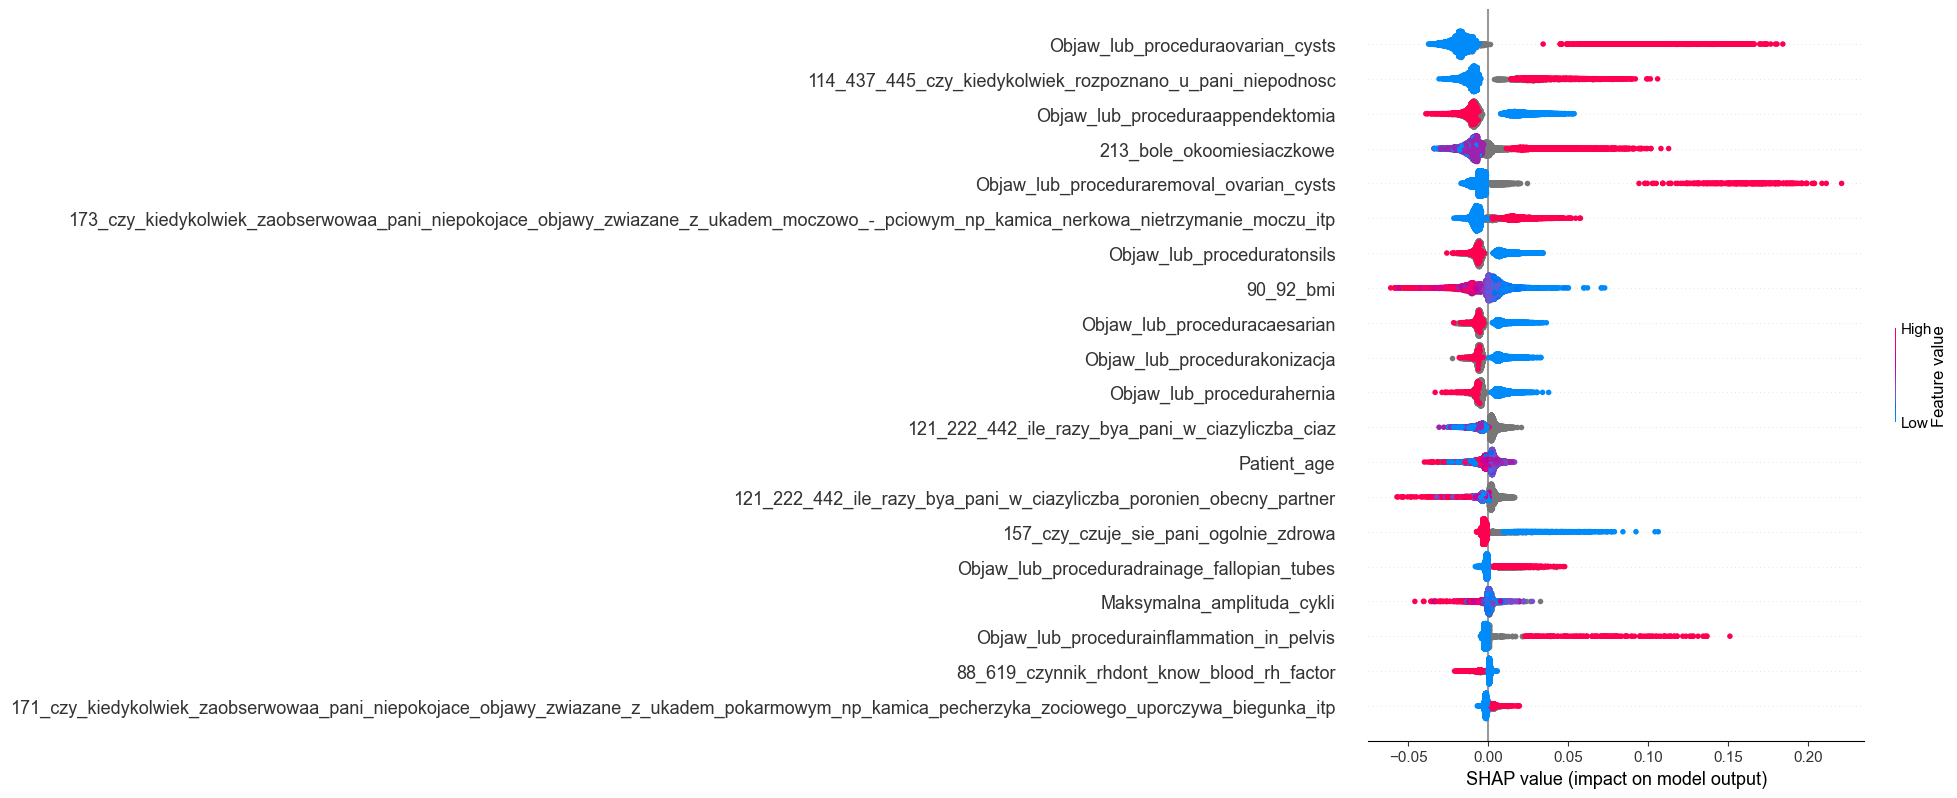

In [71]:
metrics_folds_rs = train_folds_imputation(
    target_col=y_col,
    train_cols=columns_rs,
    data=data,
    verbose=1,
    params=best_params_rs,
    calculate_shap = True
)

In [72]:
metrics_folds_rs

({'test': {'Precision': 0.2438568376068376,
   'Recall': 0.738673139158576,
   'Accuracy': 0.7331415517387257,
   'F1 weighted': 0.7824029415854793,
   'AUC': 0.8141056808761198,
   'matthews_corrcoef': 0.3099208788341377,
   'specificity': 0.7324955116696589},
  'train': {'Precision': 0.2636528514811581,
   'Recall': 0.7938915857605178,
   'Accuracy': 0.7465733141551739,
   'F1 weighted': 0.7932441661002595,
   'AUC': 0.8517804685079907,
   'matthews_corrcoef': 0.35243185459276344,
   'specificity': 0.7324955116696589}},
 {'y_test': array([0., 0., 0., ..., 1., 0., 0.]),
  'y_predicted_test': array([1, 0, 0, ..., 1, 1, 0]),
  'predictions_test': array([0.16150993, 0.05321623, 0.03778784, ..., 0.23946326, 0.09622697,
         0.02553646]),
  'y_train': array([0., 0., 1., ..., 0., 0., 0.]),
  'y_predicted_train': array([0, 0, 1, ..., 0, 0, 0]),
  'predictions_train': array([0.06565652, 0.08495045, 0.15327899, ..., 0.02279661, 0.04308463,
         0.02989765])})

In [21]:
metrics_rs=[]
for i in range(25):
    metrics_rs.append(train_folds_imputation(
        target_col=y_col,
        train_cols=columns_rs,
        data=data,
        verbose=1,
        params=best_params_rs,
        calculate_shap = False,
        random_state = i
    ))

In [22]:
error_metrics = {
    'metrics_boruta':metrics_boruta,
    'metrics_ed': metrics_ed,
    'metrics_rs':metrics_rs
}

In [23]:
save_dill(error_metrics, filename = 'error_metrics')

Done


In [29]:
results = pd.concat(
    [pd.DataFrame(metrics_boruta).test.apply(pd.Series).apply(lambda x : round(x,10)).AUC,
     pd.DataFrame(metrics_ed).test.apply(pd.Series).apply(lambda x : round(x,10)).AUC,
     pd.DataFrame(metrics_rs).test.apply(pd.Series).apply(lambda x : round(x,10)).AUC]
, axis=1)
results.columns = ['Boruta',"Expert's decision", "Recursive Feature Selection"]


Text(0, 0.5, 'AUC')

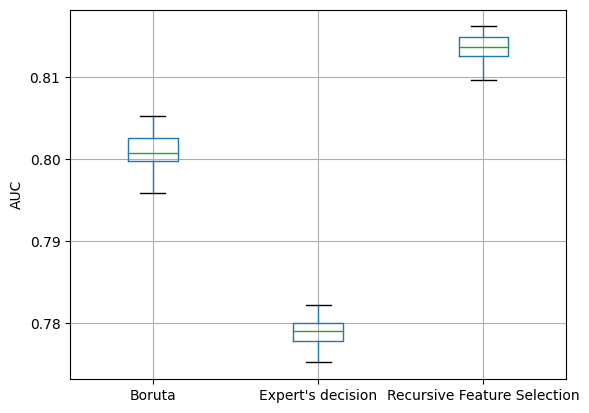

In [75]:
boxplot = results.boxplot()
boxplot.set_ylabel('AUC')

In [25]:
results_train = pd.concat(
    [pd.DataFrame(metrics_boruta).train.apply(pd.Series).apply(lambda x : round(x,10)).AUC,
     pd.DataFrame(metrics_ed).train.apply(pd.Series).apply(lambda x : round(x,10)).AUC,
     pd.DataFrame(metrics_rs).train.apply(pd.Series).apply(lambda x : round(x,10)).AUC]
, axis=1)
results_train.columns = ['Boruta',"Expert's decision", "Recursive Feature Selection"]


Text(0, 0.5, 'AUC')

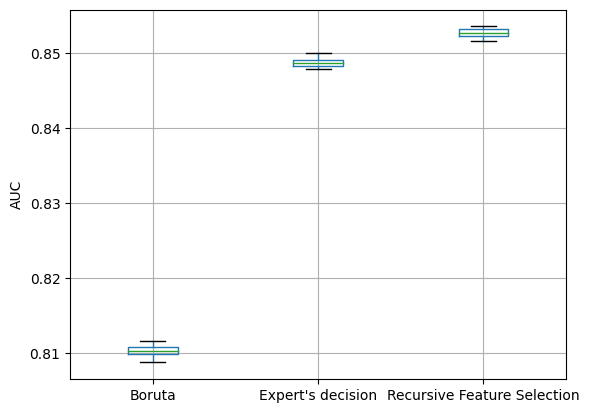

In [26]:
boxplot = results_train.boxplot()
boxplot.set_ylabel('AUC')

In [28]:
results_train.mean()

Boruta                         0.810373
Expert's decision              0.848699
Recursive Feature Selection    0.852663
dtype: float64

In [33]:
train_test_comparison = pd.DataFrame([results.mean(),results_train.mean()]).T
train_test_comparison.columns = ['test','train']
train_test_comparison = train_test_comparison.apply(lambda x : round(x,2))

In [34]:
train_test_comparison

,test,train
Boruta,0.80,0.81
Expert's decision,0.78,0.85
Recursive Feature Selection,0.81,0.85


In [35]:
train_test_comparison.to_clipboard()

## Custom model

In [12]:
columns_custom = [
    
 # ALL BORUTA   
 '173_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_moczowo_-_płciowym_(np._kamica_nerkowa,_nietrzymanie_moczu_itp.)?',
 'Objaw_lub_procedura:HISTEROSKOPIA',
 'Objaw_lub_procedura:RECURRENT_VAGINITIS',
 'Objaw_lub_procedura:TONSILS',
 'Objaw_lub_procedura:MYOMIA',
 'Objaw_lub_procedura:APPENDEKTOMIA',
 '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?',
 '213_Bóle_okołomiesiączkowe',
 'Objaw_lub_procedura:CYTOMEGALY',
 'Objaw_lub_procedura:REMOVAL_OVARIAN_CYSTS',
 'Objaw_lub_procedura:FREQUENT_URINATION',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE',
 'Objaw_lub_procedura:CAESARIAN',
 'Objaw_lub_procedura:OVARIAN_CYSTS',
 'Objaw_lub_procedura:HEADACHES',
 'Objaw_lub_procedura:KONIZACJA',
 'Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES',
 'Objaw_lub_procedura:SPOONING',
 'Objaw_lub_procedura:HERNIA',
 '157_Czy_czuje_się_Pani_ogólnie_zdrowa?',
 
 # ED ADDED
 
 '90_92_BMI',
 'patient_age',
 '211_431_Najdłuższa_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)',
 '210_430_Najkrótsza_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)',
 '209_429_Średnia_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_ciaz',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien',
 '102_Jak_długo_stara_się_Pani_zajść_w_ciążę?',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES',
 
 # RS

 'Objaw_lub_procedura:INFLAMMATION_IN_PELVIS',
 # '214_Krwawienie_miesięczne_jest_zwykle'
 
 ]

In [ ]:
best_params_custom = params_search(data,diagnosis=y_col,train_cols=columns_custom, n_HP_points_to_test= 1000)

In [129]:
best_params_custom

{'colsample_bytree': 0.4852646894723395,
 'learning_rate': 0.03,
 'max_bin': 41,
 'max_depth': 4,
 'num_leaves': 25,
 'reg_alpha': 0.2,
 'reg_lambda': 0.2,
 'subsample': 0.832546374060469,
 'subsample_freq': 42}

In [13]:
best_params_custom = {'colsample_bytree': 0.4852646894723395,
 'learning_rate': 0.03,
 'max_bin': 41,
 'max_depth': 4,
 'num_leaves': 25,
 'reg_alpha': 0.2,
 'reg_lambda': 0.2,
 'subsample': 0.832546374060469,
 'subsample_freq': 42}

In [69]:
json.dumps(best_params_custom)

'{"colsample_bytree": 0.4852646894723395, "learning_rate": 0.03, "max_bin": 41, "max_depth": 4, "num_leaves": 25, "reg_alpha": 0.2, "reg_lambda": 0.2, "subsample": 0.832546374060469, "subsample_freq": 42}'

In [14]:
columns_custom_mapping = {
# ALL BORUTA   
 '173_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_moczowo_-_płciowym_(np._kamica_nerkowa,_nietrzymanie_moczu_itp.)?':'Urinary-genital system symptoms',
 'Objaw_lub_procedura:HISTEROSKOPIA'	:	'HYSTEROSCOPY',
 'Objaw_lub_procedura:RECURRENT_VAGINITIS'	:	'RECURRENT VAGINITIS',
 'Objaw_lub_procedura:TONSILS'	:	'TONSILS',
 'Objaw_lub_procedura:MYOMIA'	:	'MYOMIA',
 'Objaw_lub_procedura:APPENDEKTOMIA'	:	'appendectomy',
 '114_437_445_Czy_kiedykolwiek_rozpoznano_u_Pani_niepłodność?'	:	'Diagnosed Infertility',
 '213_Bóle_okołomiesiączkowe'	:	'Menstrual pains',
 'Objaw_lub_procedura:CYTOMEGALY'	:	'CYTOMEGALY',
 'Objaw_lub_procedura:REMOVAL_OVARIAN_CYSTS'	:	'REMOVAL of OVARIAN CYSTS',
 'Objaw_lub_procedura:FREQUENT_URINATION'	:	'FREQUENT URINATION',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE'	:	'REDUCTION OF SEX DRIVE',
 'Objaw_lub_procedura:CAESARIAN'	:	'Caesarean section',
 'Objaw_lub_procedura:OVARIAN_CYSTS'	:	'OVARIAN CYSTS',
 'Objaw_lub_procedura:HEADACHES'	:	'HEADACHES',
 'Objaw_lub_procedura:KONIZACJA'	:	'Conization',
 'Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES'	:	'DRAINAGE of FALLOPIAN TUBES',
 'Objaw_lub_procedura:SPOONING'	:	'SPOONING',
 'Objaw_lub_procedura:HERNIA'	:	'HERNIA',
 '157_Czy_czuje_się_Pani_ogólnie_zdrowa?'	:	'Feeling generally healthy',

 
 # ED ADDED
 
 '90_92_BMI'	:	'BMI',
 'patient_age'	:	'Patient age',
 '211_431_Najdłuższa_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)'	:	'Longest menstrual cycle lenght',
 '210_430_Najkrótsza_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)'	:	'Shortest menstrual cycle lenght',
 '209_429_Średnia_długość_cyklu_miesiączkowego_(liczba_dni_od_pierwszego_dnia_miesiączki_do_pierwszego_dnia_następnej_miesiączki)'	:	'Average menstrual cycle lenght',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_ciaz'	:	'Number of pregnancies',
 '121_222_442_Ile_razy_była_Pani_w_ciąży?:liczba_poronien'	:	'Number of miscarriages',
 '102_Jak_długo_stara_się_Pani_zajść_w_ciążę?'	:	'Years of trying to get pregnant',
 '655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:ORAL_CONTRACEPTIVES'	:	'ORAL CONTRACEPTIVES',

 
 # RS

 'Objaw_lub_procedura:INFLAMMATION_IN_PELVIS' : 'INFLAMMATION IN PELVIS',
 # '214_Krwawienie_miesięczne_jest_zwykle':'Abundance of the period'
 # 'Objaw_lub_procedura:BLEEDING_AFTER_INTERCOURSE': 'BLEEDING AFTER INTERCOURSE'
  '427_W_jakim_wieku_miała_Pani_pierwszą_miesiączkę?':'First menarche'
}

In [26]:
pd.Series(list(columns_custom_mapping.values())).str.capitalize().tolist()

['Urinary-genital system symptoms',
 'Hysteroscopy',
 'Recurrent vaginitis',
 'Tonsils',
 'Myomia',
 'Appendectomy',
 'Diagnosed infertility',
 'Menstrual pains',
 'Cytomegaly',
 'Removal of ovarian cysts',
 'Frequent urination',
 'Reduction of sex drive',
 'Caesarean section',
 'Ovarian cysts',
 'Headaches',
 'Conization',
 'Drainage of fallopian tubes',
 'Spooning',
 'Hernia',
 'Feeling generally healthy',
 'Bmi',
 'Patient age',
 'Longest menstrual cycle lenght',
 'Shortest menstrual cycle lenght',
 'Average menstrual cycle lenght',
 'Number of pregnancies',
 'Number of miscarriages',
 'Years of trying to get pregnant',
 'Oral contraceptives',
 'Inflammation in pelvis',
 'First menarche']

In [15]:
data_custom = data.copy()
data_custom = data_custom[list(columns_custom_mapping.keys())+[y_col]]
data_custom.rename(columns=columns_custom_mapping, inplace=True)

In [16]:
data_custom.shape

(11819, 32)

In [16]:
import matplotlib.pyplot as pl

In [17]:
pl.rcParams['font.family'] = 'Arial'
#pl.rcParams['font.sans-serif'] = 'Montserrat-Black'
pl.rcParams['font.size'] = 12.0

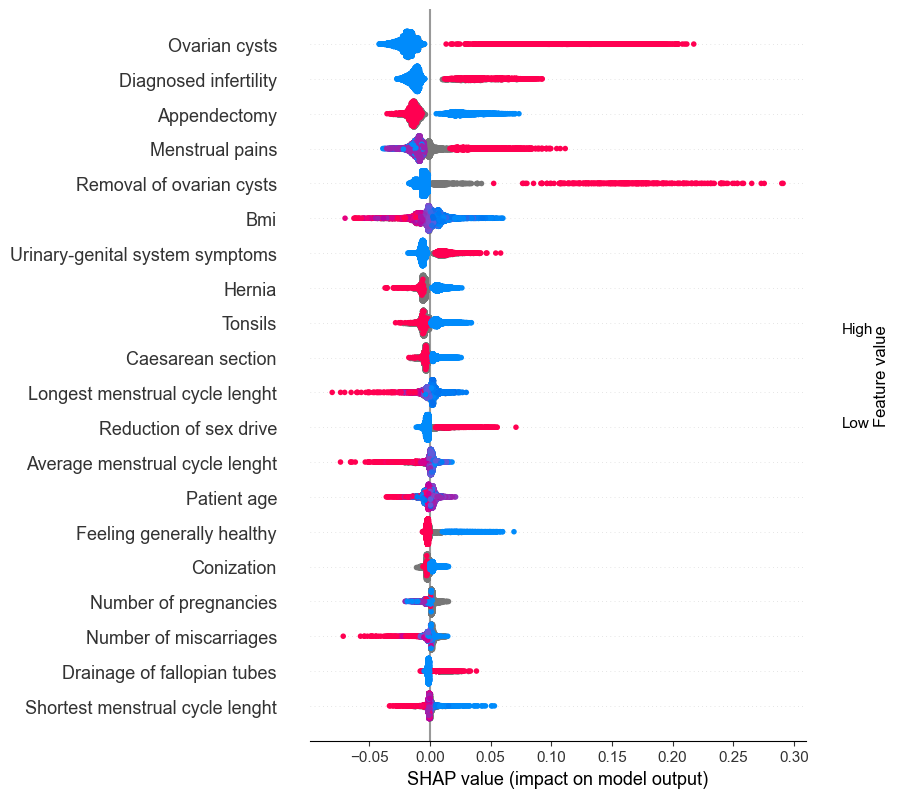

In [22]:
metrics_folds_custom, results_folds_custom = train_folds_imputation(
    target_col=y_col,
    train_cols=list(columns_custom_mapping.values()),
    data=data_custom,
    verbose=1,
    params=best_params_custom,
    calculate_shap = True
)

In [23]:
metrics_folds_custom

{'test': {'Precision': 0.2609452015076834,
  'Recall': 0.7281553398058253,
  'Accuracy': 0.7559015145105339,
  'F1 weighted': 0.7993017459970645,
  'F1': array([0.84778135, 0.38420491]),
  'AUC': 0.8165119182715639,
  'matthews_corrcoef': 0.32801852079497096,
  'specificity': 0.7591420202211093},
 'train': {'Precision': 0.2860968704568062,
  'Recall': 0.7562702265372169,
  'Accuracy': 0.7771596581775108,
  'F1 weighted': 0.8155893764030151,
  'F1': array([0.86235775, 0.41514462]),
  'AUC': 0.8469731253671471,
  'matthews_corrcoef': 0.36665200067880765,
  'specificity': 0.7795993574600775}}

In [22]:

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score,
    f1_score,
    matthews_corrcoef,
    precision_score, 
    recall_score,
    roc_curve,
    precision_recall_curve,
    auc
)

In [23]:
results_folds_custom

{'y_test': array([0., 0., 0., ..., 1., 0., 0.]),
 'y_predicted_test': array([0, 0, 0, ..., 1, 0, 0]),
 'predictions_test': array([0.18174962, 0.06534446, 0.0503805 , ..., 0.25932089, 0.08371563,
        0.03371047]),
 'y_train': array([0., 0., 1., ..., 0., 0., 0.]),
 'y_predicted_train': array([0, 0, 0, ..., 0, 0, 0]),
 'predictions_train': array([0.06732822, 0.0719281 , 0.1465432 , ..., 0.02042648, 0.04180716,
        0.03556908])}

In [24]:
subset = 'train'

In [25]:
roc_auc_score(results_folds_custom[f'y_{subset}'], results_folds_custom[f'predictions_{subset}'], average = 'weighted')

0.8469731253671471

In [26]:
print(classification_report(results_folds_custom[f'y_{subset}'], results_folds_custom[f'y_predicted_{subset}']))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94     42332
         1.0       0.47      0.54      0.50      4944

    accuracy                           0.89     47276
   macro avg       0.71      0.73      0.72     47276
weighted avg       0.90      0.89      0.89     47276



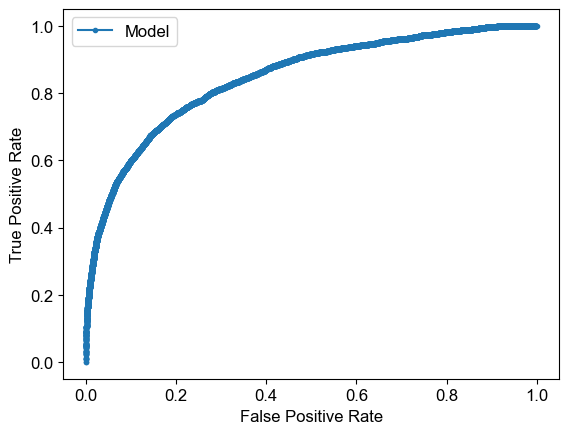

In [27]:
fpr, tpr, thresholds = roc_curve(results_folds_custom[f'y_{subset}'], results_folds_custom[f'predictions_{subset}'])
# plot the roc curve for the model
pl.plot(fpr, tpr, marker='.', label='Model')
# axis labels
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
# show the legend
pl.legend()
# show the plot
pl.show()

# Summary of feature selection

In [21]:
columns_boruta.__len__()

20

In [22]:
columns_ed.__len__()

67

In [23]:
columns_rs.__len__()

165

In [12]:
list(set(columns_boruta)-set(columns_ed))

['Objaw_lub_procedura:OVARIAN_CYSTS',
 'Objaw_lub_procedura:HISTEROSKOPIA',
 'Objaw_lub_procedura:APPENDEKTOMIA',
 'Objaw_lub_procedura:HERNIA',
 'Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES',
 'Objaw_lub_procedura:REMOVAL_OVARIAN_CYSTS',
 '173_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_moczowo_-_płciowym_(np._kamica_nerkowa,_nietrzymanie_moczu_itp.)?',
 '157_Czy_czuje_się_Pani_ogólnie_zdrowa?',
 'Objaw_lub_procedura:SPOONING',
 'Objaw_lub_procedura:CYTOMEGALY',
 'Objaw_lub_procedura:CAESARIAN',
 'Objaw_lub_procedura:TONSILS']

In [14]:
list(set(columns_boruta)-set(columns_ed)).__len__()

12

In [13]:
list(set(columns_boruta)-set(columns_rs))

['Objaw_lub_procedura:FREQUENT_URINATION',
 'Objaw_lub_procedura:HEADACHES',
 'Objaw_lub_procedura:REDUCTION_OF_SEX_DRIVE']

In [18]:
list(set(columns_ed)-set(columns_rs)-set(columns_boruta)).__len__()

13

In [44]:
pd.DataFrame([metrics_folds_boruta,metrics_folds_ed,metrics_folds_rs], index = ['metrics_folds_boruta','metrics_folds_ed','metrics_folds_rs']).test.apply(pd.Series).apply(lambda x : round(x,2))

,Precision,Recall,Accuracy,F1 weighted,AUC,matthews_corrcoef
metrics_folds_boruta,0.45,0.41,0.89,0.88,0.80,0.37
metrics_folds_ed,0.36,0.38,0.87,0.87,0.78,0.30
metrics_folds_rs,0.47,0.44,0.89,0.89,0.81,0.39


# Normaliation

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
normalize = MinMaxScaler()

In [26]:
data_normalized = pd.DataFrame(normalize.fit_transform(data), columns = data.columns)

# Imputation

## Mean

In [27]:
from sklearn.impute import SimpleImputer

# To calculate mean use imputer class
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [61]:
data_fillna = data_normalized.copy()

In [62]:
data_mean = imputer.fit_transform(data_fillna[columns_rs].values)

In [63]:
data_mean = pd.concat([pd.DataFrame(data_mean, columns = columns_rs),data.reset_index(drop=True).endometrioza], axis = 1)

## Mice

In [30]:
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(random_state=0)

In [31]:
data_mice = imp_mean.fit_transform(data_normalized[columns_rs].values)

In [32]:
data_mice.shape

(11819, 165)

In [88]:
# start the KNN training
# imputed_training_mice_wo_y=mice(data_fillna_mice.values)

In [33]:
data_fillna_mice = pd.concat([pd.DataFrame(data_mice, columns = columns_rs),data.reset_index(drop=True).endometrioza], axis = 1)

In [34]:
data_fillna_mice.shape

(11819, 166)

In [35]:
data_fillna_mice.head()

,655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:CONDOM,Objaw_lub_procedura:FEVER,Objaw_lub_procedura:VISION_PROBLEMS,Objaw_lub_procedura:LYMPH_NODE_ENLARGEMENT,Objaw_lub_procedura:KIDNEY_STONES,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):MEDROXYPROGESTERON,patient_age,568_Czy_stwierdzono_u_Pani_przedwczesne_wygaśnięcie_funkcji_jajnika?,Objaw_lub_procedura:EPILEPSY,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):CLOMIFEN,...,Objaw_lub_procedura:SPIT_OUT_OF_BREAST_NIPPLE,655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:PERMANENT_CONTRACEPTION,Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):FSH,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):DYDROGESTERONE,Objaw_lub_procedura:HERNIA,Objaw_lub_procedura:DIZZINESS,"171_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_pokarmowym_(np._kamica_pęcherzyka_żółciowego,_uporczywa_biegunka_itp.)?","187_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_limfatycznym_(np._anemia,_powiększenie_węzłów_chłonnych_itp.)?",endometrioza
0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.474695,-0.044021,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.034563,0.000000,0.000000,0.000000,0.0
1,0.000000,1.00000,1.00000,0.000000,0.000000,0.000000,0.445026,0.036100,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.080194,1.000000,-0.010701,0.028624,0.0
2,0.268953,0.13013,0.19797,0.027656,0.037494,0.006457,0.438045,0.021136,0.006366,0.13977,...,0.023008,0.001338,0.108703,0.043924,0.177575,0.042257,0.083326,0.221274,0.159760,1.0
3,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.486911,-0.051368,0.000000,0.00000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.018072,0.000000,1.000000,1.000000,0.0
4,1.000000,0.00000,1.00000,0.000000,0.000000,0.000000,0.612565,0.095758,0.000000,0.00000,...,0.000000,0.000545,0.000000,0.000000,0.000000,0.037916,0.000000,0.000000,0.000000,0.0


In [36]:
data_fillna_mice.to_csv(
    os.path.join(
        os.getenv('data_path'),'data_fillna_mice.csv'
    ),
    index = False

)

In [ ]:
data_fillna_mice = pd.read_csv(os.path.join(
    os.getenv('data_path'),'data_fillna_mice.csv'
))

## KNN

In [37]:
from sklearn.impute import KNNImputer
imp_knn = IterativeImputer(random_state=0)

In [38]:
data_knn = imp_knn.fit_transform(data_normalized[columns_rs].values)

In [39]:
data_knn.shape

(11819, 165)

In [93]:
# start the KNN training
# imputed_training_mice_wo_y=mice(data_fillna_mice.values)

In [40]:
data_fillna_knn = pd.concat([pd.DataFrame(data_knn, columns = columns_rs),data.reset_index(drop=True).endometrioza], axis = 1)

In [41]:
data_fillna_knn.head()

,655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:CONDOM,Objaw_lub_procedura:FEVER,Objaw_lub_procedura:VISION_PROBLEMS,Objaw_lub_procedura:LYMPH_NODE_ENLARGEMENT,Objaw_lub_procedura:KIDNEY_STONES,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):MEDROXYPROGESTERON,patient_age,568_Czy_stwierdzono_u_Pani_przedwczesne_wygaśnięcie_funkcji_jajnika?,Objaw_lub_procedura:EPILEPSY,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):CLOMIFEN,...,Objaw_lub_procedura:SPIT_OUT_OF_BREAST_NIPPLE,655_594_119_223_439_Czy_stosuje_Pani_środki_antykoncepcyjne?:PERMANENT_CONTRACEPTION,Objaw_lub_procedura:DRAINAGE_FALLOPIAN_TUBES,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):FSH,110_123_226_491_Czy_przyjmuje_Pani_obecnie_lub_przyjmowała_jakiekolwiek_leki_(inne_niż_wymienione_w_zakładce_Wywiad_wstępny):DYDROGESTERONE,Objaw_lub_procedura:HERNIA,Objaw_lub_procedura:DIZZINESS,"171_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_pokarmowym_(np._kamica_pęcherzyka_żółciowego,_uporczywa_biegunka_itp.)?","187_Czy_kiedykolwiek_zaobserwowała_Pani_niepokojące_objawy_związane_z_układem_limfatycznym_(np._anemia,_powiększenie_węzłów_chłonnych_itp.)?",endometrioza
0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.474695,-0.044021,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.034563,0.000000,0.000000,0.000000,0.0
1,0.000000,1.00000,1.00000,0.000000,0.000000,0.000000,0.445026,0.036100,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.080194,1.000000,-0.010701,0.028624,0.0
2,0.268953,0.13013,0.19797,0.027656,0.037494,0.006457,0.438045,0.021136,0.006366,0.13977,...,0.023008,0.001338,0.108703,0.043924,0.177575,0.042257,0.083326,0.221274,0.159760,1.0
3,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.486911,-0.051368,0.000000,0.00000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.018072,0.000000,1.000000,1.000000,0.0
4,1.000000,0.00000,1.00000,0.000000,0.000000,0.000000,0.612565,0.095758,0.000000,0.00000,...,0.000000,0.000545,0.000000,0.000000,0.000000,0.037916,0.000000,0.000000,0.000000,0.0


In [42]:
data_fillna_knn.to_csv(
    os.path.join(
        os.getenv('data_path'),'data_fillna_knn.csv'
    ),
    index = False

)

In [66]:
col_subsets = {
    'columns_boruta':columns_boruta,'columns_ed': columns_ed
}
imputed_datasets = {}
for col_subset_name, col_subset in col_subsets.items():
    
    imputed_datasets[col_subset_name] = {}

    data_mean = imputer.fit_transform(data_fillna[col_subset].values)
    data_mean = pd.concat([pd.DataFrame(data_mean, columns = col_subset),data.reset_index(drop=True).endometrioza], axis = 1)

    imputed_datasets[col_subset_name]['imputed_mean'] = data_mean

    data_mice = imp_mean.fit_transform(data_normalized[col_subset].values)
    data_fillna_mice = pd.concat([pd.DataFrame(data_mice, columns = col_subset),data.reset_index(drop=True).endometrioza], axis = 1)


    imputed_datasets[col_subset_name]['imputed_mice'] = data_fillna_mice


    data_knn = imp_knn.fit_transform(data_normalized[col_subset].values)
    data_fillna_knn = pd.concat([pd.DataFrame(data_knn, columns = col_subset),data.reset_index(drop=True).endometrioza], axis = 1)


    imputed_datasets[col_subset_name]['imputed_knn'] = data_fillna_knn

In [67]:
imputed_datasets.keys()

dict_keys(['columns_boruta', 'columns_ed'])

# UMAP Visualization

In [15]:
import umap
import umap.plot

In [23]:
mapper = umap.UMAP(n_neighbors=50,min_dist=0.3,random_state=42,transform_seed=42).fit(imputed_datasets['columns_boruta']['imputed_mean'].drop(columns = 'endometrioza'))

<AxesSubplot: >

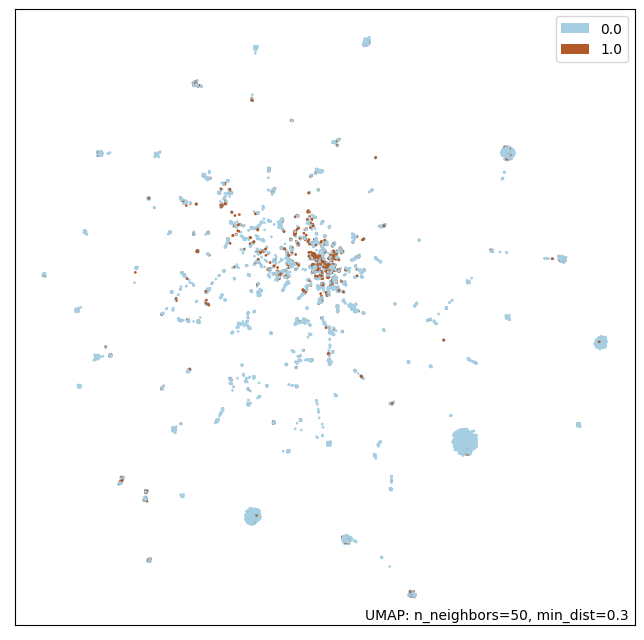

In [24]:
umap.plot.points(mapper, labels=imputed_datasets['columns_boruta']['imputed_mean'].endometrioza, color_key_cmap='Paired')

# Comparison of models

In [64]:
datasets = {
    'imputed_mean' : data_mean, 
    'imputed_mice' : data_fillna_mice, 
    'imputed_knn' : data_fillna_knn
}

In [ ]:
imputed_datasets['columns_rs'] = datasets

In [69]:
save_dill(imputed_datasets, filename = 'whole_imputed_data')

Done


In [14]:
imputed_datasets = get_dill('whole_imputed_data', env_variable= 'data_path')

In [23]:
imputed_datasets.keys()

dict_keys(['columns_boruta', 'columns_ed', 'columns_rs'])

In [ ]:
col_subsets = {
    'columns_boruta':columns_boruta,'columns_ed': columns_ed, 'columns_rs': columns_rs 
}
params_subsets = {
    'columns_boruta':best_params_boruta,'columns_ed': best_params_ed, 'columns_rs': best_params_rs

}

In [73]:
metrics_imputed = {}
for columns_subset, datasets_dict in imputed_datasets.items():

    metrics_imputed[columns_subset] = {}

    for data_name, data_imputed in datasets_dict.items():
        metrics_imputed[columns_subset][data_name] = []
        for i in range(25):
            metrics_imputed[columns_subset][data_name].append(train_folds_imputation(
                target_col=y_col,
                train_cols=col_subsets[columns_subset],
                data=data_imputed,
                verbose=1,
                params=params_subsets[columns_subset],
                calculate_shap = False,
                random_state = i
            ))

In [74]:

save_dill(metrics_imputed, filename = 'metrics_imputed')

Done


In [25]:
metrics_imputed = get_dill('metrics_imputed',env_variable='data_path')

In [26]:
metrics_imputed

{'columns_boruta': {'imputed_mean': [{'test': {'Precision': 0.4318181818181818,
     'Recall': 0.4457928802588997,
     'Accuracy': 0.8807005668838311,
     'F1 weighted': 0.8815374622722018,
     'AUC': 0.8004853451542087,
     'matthews_corrcoef': 0.37202985019991786},
    'train': {'Precision': 0.4358377014172005,
     'Recall': 0.45408576051779936,
     'Accuracy': 0.8814409002453676,
     'F1 weighted': 0.8825111480126592,
     'AUC': 0.8101720608813608,
     'matthews_corrcoef': 0.378540491898015}},
   {'test': {'Precision': 0.4279312920089619,
     'Recall': 0.46359223300970875,
     'Accuracy': 0.879092985870209,
     'F1 weighted': 0.8812155029639103,
     'AUC': 0.7978889022420093,
     'matthews_corrcoef': 0.3777068594818558},
    'train': {'Precision': 0.43345289786671704,
     'Recall': 0.46440129449838186,
     'Accuracy': 0.8805101954480075,
     'F1 weighted': 0.8823194151087331,
     'AUC': 0.8085831725416318,
     'matthews_corrcoef': 0.38176630297718644}},
   {'test'

In [31]:
pd.DataFrame(metrics_imputed).columns_boruta.explode().apply(pd.Series).test.apply(pd.Series).apply(lambda x : round(x,10)).AUC

imputed_mean    0.800485
imputed_mean    0.797889
imputed_mean    0.801883
imputed_mean    0.801099
imputed_mean    0.803744
                  ...   
imputed_knn     0.794915
imputed_knn     0.794805
imputed_knn     0.797175
imputed_knn     0.796975
imputed_knn     0.796250
Name: AUC, Length: 75, dtype: float64

In [27]:
metrics_df = pd.DataFrame(metrics_imputed).reset_index().melt(id_vars='index')

In [28]:
metrics_df = metrics_df.explode('value')

In [29]:
metrics_df['AUC'] = metrics_df.value.apply(pd.Series).test.apply(pd.Series).apply(lambda x : round(x,10)).AUC

In [30]:
metrics_df['method of imputation'] = metrics_df['index'].str.split('_').apply(lambda x: x[-1])

In [31]:
metrics_df['method of feature selection'] = metrics_df['variable'].str.split('_').apply(lambda x: x[-1])

In [33]:
metrics_df.groupby(['method of imputation','method of feature selection']).AUC.mean()

method of imputation  method of feature selection
knn                   boruta                         0.797225
                      ed                             0.774471
                      rs                             0.812451
mean                  boruta                         0.801175
                      ed                             0.778708
                      rs                             0.813624
mice                  boruta                         0.797225
                      ed                             0.774471
                      rs                             0.812451
Name: AUC, dtype: float64

<AxesSubplot: title={'center': 'AUC'}, xlabel='[method of imputation, method of feature selection]'>

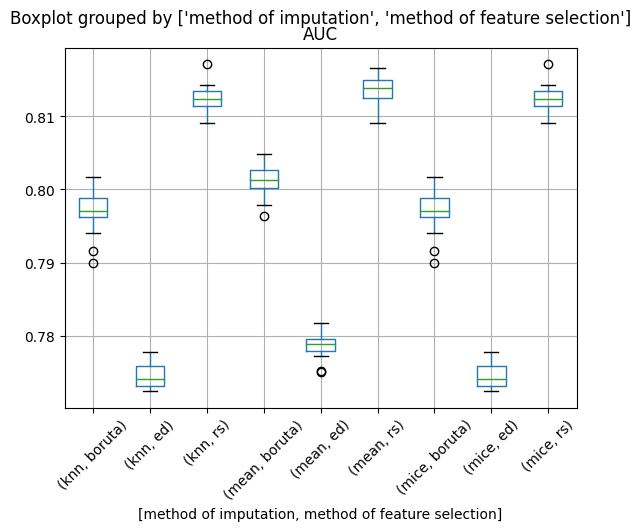

In [12]:
metrics_df.boxplot(column=['AUC'],by=['method of imputation','method of feature selection'], rot=45)

In [ ]:
results = pd.concat(
    [pd.DataFrame(metrics_boruta).test.apply(pd.Series).apply(lambda x : round(x,10)).AUC,
     pd.DataFrame(metrics_ed).test.apply(pd.Series).apply(lambda x : round(x,10)).AUC,
     pd.DataFrame(metrics_rs).test.apply(pd.Series).apply(lambda x : round(x,10)).AUC]
, axis=1)
results.columns = ['Boruta',"Expert's decision", "Recursive Feature Selection"]
